#### Import Packages

In [1]:
# Increase width of the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data')
print(os.getcwd())
import numpy as np
import pandas as pd
pd.set_option('mode.use_inf_as_na', True)

# Plotting (x,y) with MatPlotLib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
plt.style.use("default") # notebook, paper, poster
# Plotting Tick Marks # https://matplotlib.org/stable/api/ticker_api.html
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator

# Plotting (x(t),y(t))
import datetime
from datetime import timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
years  =  mdates.YearLocator()
months =  mdates.MonthLocator()
days   =  mdates.DayLocator()
year_name = DateFormatter("%Y")
month_name = DateFormatter("%b")
day_name = DateFormatter('%d')

# Statistics/Regression Models (SciPy)
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData

# Prohibit Warnings ()
import warnings 
warnings.filterwarnings('ignore')
#warnings.filterwarnings("error", message=".*check_inverse*.",category=UserWarning, append=False)

J:\Chomiak_Python\Chomiak_Notebooks\Siberia_Data


#### ArcticGRO_4 @ River Discharge Dataset (1999 - 2022)

In [2]:
# ArcticGRO_4 @ River Discharge Dataset (1999 - 2022)
AGRO4_Q = "Arctic_GRO4_Discharge.txt"
dfq = pd.read_csv(AGRO4_Q, delim_whitespace=True, parse_dates=[0], index_col=[0], na_values = {'NA','A','', 'P'})
dfq.columns = dfq.columns.str.strip()
dfq= dfq.drop(columns={'Yukon_flag','Yukon','Mackenzie_flag','Mackenzie','Ob_flag','Lena_flag','Yenisey_flag', 'Kolyma_flag', 'Kolyma'})
dfq = dfq.rename(columns={"Yenisey":"q_m3/s"})

# Add Column for Daily Volume Export (km3) 
dfq['V_km3'] = (dfq['q_m3/s']) * (86400) * (10**-9)    #   86400 [s] = 24 [hr] = 1 [d]

# Reformat Dates: Add columns for YYYY,MM,DD)
dfq['Date'] = dfq.index
dfq['year'] = pd.DatetimeIndex(dfq.index).year
dfq['month'] = pd.DatetimeIndex(dfq.index).month
dfq['day'] = pd.DatetimeIndex(dfq.index).day

# Reformat Date: Add 'month_day' column with format 1900-MM-DD)
dfq['month_day'] = dfq['Date'].dt.strftime('%m-%d')
dfq['month_day'] = pd.to_datetime(dfq['month_day'],format='%m-%d',errors='coerce')
dfq['month_'] = dfq['Date'].dt.strftime('%m')
dfq['month_'] = pd.to_datetime(dfq['month_'],format='%m',errors='coerce')

# Print Shape
print('Yenisey River Discharge [m3/s]')
print('dfq =', dfq.shape, 'Arctic_GRO4_Discharge.txt') # Total
print()

min_Q_dfq = dfq['q_m3/s'].min()

###################################################################################################
# Daily-Averaged Groupby (Mean, Mean, Max, Min) 
dfq_daily = dfq.groupby(dfq['month_day']).mean() # mean
dfq_daily_sd = dfq.groupby(dfq['month_day']).std() # sd = standard deviation
dfq_daily_max = dfq.groupby(dfq['month_day']).max() # max = maximum
dfq_daily_min = dfq.groupby(dfq['month_day']).min() # min = minimum
dfq_daily_sum = dfq.groupby(dfq['month_day']).sum() # sum = sum

# Create columns for Statistical Data 
dfq_daily['q_sd'] = dfq_daily_sd['q_m3/s'] # sd = standard deviation
dfq_daily['q_max'] = dfq_daily_max['q_m3/s'] # max = maximum
dfq_daily['q_min'] = dfq_daily_min['q_m3/s'] # min = minimum
dfq_daily['q_sum'] = dfq_daily_sum['q_m3/s'] # sum = sum
dfq_daily['m_sd'] = dfq_daily_sd['q_m3/s'] # sd = standard deviation

dfq_daily['Q_sd_neg'] = dfq_daily['q_m3/s'] - dfq_daily['q_sd']
dfq_daily['Q_sd_pos'] = dfq_daily['q_m3/s'] + dfq_daily['q_sd']

# Make values below a lower limit be changes to the minimum of the main dataset
dfq_daily['Q_sd_neg'] = dfq_daily['Q_sd_neg'].where(dfq_daily['Q_sd_neg'] >= min_Q_dfq, min_Q_dfq)
dfq_daily['Q_sd_pos'] = dfq_daily['Q_sd_pos'].where(dfq_daily['Q_sd_pos'] >= min_Q_dfq, min_Q_dfq)

# Define Upper and Lower Limits assuming a 95% confidence interval
dfq_daily['lower'] = dfq_daily['q_m3/s'] - 1.96 * dfq_daily['q_sd'] 
dfq_daily['upper'] = dfq_daily['q_m3/s'] + 1.96 * dfq_daily['q_sd']

# Make values below a lower limit be changes to the minimum of the main dataset
dfq_daily['lower'] = dfq_daily['lower'].where(dfq_daily['lower'] >= min_Q_dfq, min_Q_dfq)
dfq_daily['upper'] = dfq_daily['upper'].where(dfq_daily['upper'] >= min_Q_dfq, min_Q_dfq)

Yenisey River Discharge [m3/s]
dfq = (8550, 10) Arctic_GRO4_Discharge.txt



#### ArcticGRO_4 @ River Solutes Dataset (2003 - 2022)

In [3]:
# Import ARCTICGRO4
AGRO4 = 'Arctic_GRO4_Chem.txt'
df4 = pd.read_csv(AGRO4, delim_whitespace=True, parse_dates=[1], na_values = {'NA','BD','','bdl'})
df4.columns = df4.columns.str.strip()
# Remove Apostraphe from Ob
df4['River'] = df4['River'].astype(str).str.replace("[']", "", regex=True)
df4.index = df4['River']
df4 = df4.rename(columns={"Temp":"T"})

# Reformat Dates
df4['year'] = pd.DatetimeIndex(df4['Date']).year
df4['month'] = pd.DatetimeIndex(df4['Date']).month
df4['day'] = pd.DatetimeIndex(df4['Date']).day
df4['month_day'] = df4['Date'].dt.strftime('%m-%d')
df4['month_day'] = pd.to_datetime(df4['month_day'],format='%m-%d',errors='coerce')
df4['month_'] = df4['Date'].dt.strftime('%m')
df4['month_'] = pd.to_datetime(df4['month_'],format='%m',errors='coerce')
df4 = df4.sort_values(by = ['month_','year'])

# Add Total Organic Carbon
df4['TOC'] = df4['DOC'] + df4['POC']

# Convert NO3 dtype from object to numeric
df4['NO3'] = pd.to_numeric(df4['NO3'])
df4['NH4'] = pd.to_numeric(df4['NH4'])

# Organic Ratios
df4['NP'] = df4['NO3']/df4['PO4']
df4['DOC_POC'] = df4['DOC']/df4['POC']

# Geochemical Ratios
df4['Ca/Mg'] = (df4['Ca'] / df4['Mg'])
df4['Ca/Na'] = (df4['Ca'] / df4['Na'])
df4['Mg/Na'] = (df4['Mg'] / df4['Na'])
df4['Cl/Na'] = (df4['Cl'] / df4['Na'])
df4['(Ca + Mg)/Alk'] = (df4['Ca'] + df4['Mg'])/df4['Alk']
df4['(Ca + Mg)/SO4'] = (df4['Ca'] + df4['Mg'])/df4['SO4']
df4['(Ca + Mg)/NO3'] = (df4['Ca'] + df4['Mg'])/df4['NO3']
df4['acid/alk'] = (df4['NO3'] + df4['SO4'])/df4['Alk']

# Isolate Yenisey River Data
dfo = df4[df4.index == 'Ob']
dfy = df4[df4.index == 'Yenisey']
dfl = df4[df4.index == 'Lena']

dfo.index = dfo['Date']
dfy.index = dfy['Date']
dfl.index = dfl['Date']

dfy = dfy.sort_values(by = ['year', 'month', 'day']) 
dfo = dfo.sort_values(by = ['year', 'month', 'day']) 
dfl = dfl.sort_values(by = ['year', 'month', 'day']) 

# Drop Data from (2005-06-11) ==== is shit
dfy = dfy.drop(labels='2005-06-11 00:00:00')

# Clean Up POC
dfy_no = [dfy['POC'] < 0]
dfy[dfy['POC'] < 0] = 0

# Print Shape
print('Biogeochemical Datasets')
print('   Lena @', dfl.shape, 'Arctic_GRO4_Chem.txt') # Total
print('Yenisei @', dfy.shape, 'Arctic_GRO4_Chem.txt') # Total
print('     Ob @', dfo.shape, 'Arctic_GRO4_Chem.txt') # Total
print()

Biogeochemical Datasets
   Lena @ (91, 73) Arctic_GRO4_Chem.txt
Yenisei @ (91, 73) Arctic_GRO4_Chem.txt
     Ob @ (92, 73) Arctic_GRO4_Chem.txt



#### River Discharge and Merge

In [4]:
# I want to look at mass transport for Freshwater, Particulates, Organic Matter, Dissolved Geochemicals. 
#df = dfy[['Date', 'month_day', 'month_', 'year', 'month', 'T', 'pH', 'TOC', 'POC', 'DOC', 'DOC_POC', 'PON', 'TDN', 'TSS', 'Alk', 'Ca', 'Mg', 'SiO2', 'SO4', 'NO3', 'Na', 'K', 'Cl','camg_alk', 'camg_so4', 'camg_no3','acid_alk','Cond','NH4', 'TDP', 'PO4', 'a254']]

# River Discharge
yq = dfq['q_m3/s']

# Merge Biogeochemical Parameters with Discharge Data
dfc = pd.merge(yq, dfy, left_index=True, right_index=True)

# Rename Column for Discharge
#dfc = dfc.rename(columns={'Yenisey': 'Q'})

dfc = dfc.drop(columns=['month_day', 'month_', 'year', 'month'])

# Structures
print('Arctic_GRO_4_Combined')
print('dfc = ', dfc.shape)

# Reformat Dates: Add columns for YYYY,MM,DD)
dfc['Date'] = dfc.index
dfc['year'] = pd.DatetimeIndex(dfc['Date']).year
dfc['month'] = pd.DatetimeIndex(dfc['Date']).month
dfc['day'] = pd.DatetimeIndex(dfc['Date']).day

# Reformat Date: Add 'month_day' column with format 1900-MM-DD)
dfc['month_day'] = dfc['Date'].dt.strftime('%m-%d')
dfc['month_day'] = pd.to_datetime(dfc['month_day'],format='%m-%d',errors='coerce')
dfc['month_'] = dfc['Date'].dt.strftime('%m')
dfc['month_'] = pd.to_datetime(dfc['month_'],format='%m',errors='coerce')

# Sort Values based on Month-Day
dfc = dfc.sort_index() 

print()
print(dfc.columns)
print()
dfc.isna().sum()

Arctic_GRO_4_Combined
dfc =  (89, 70)

Index(['q_m3/s', 'River', 'Date', 'T', 'pH', 'Cond', 'Alk', 'a254', 'a375',
       'a412', 'a420', 'a440', 'H2O-2H', 'H2O-18O', 'DOC', 'DOC-13C',
       'DOC-14C', 'DOC-fm', 'TDN', 'NO3', 'NH4', 'TDP', 'PO4', 'SiO2', 'Na',
       'K', 'Mg', 'Ca', 'As', 'Ba', 'Cl', 'SO4', 'Li', 'Rb', 'Sr', 'U', 'F',
       'UTHg', 'UMeHg', 'TSS', 'POC', 'POC-13C', 'POC-14C', 'POC-fm', 'PON',
       'PON-15N', 'Sample_depth_1', 'TSS_1', 'POC_1', 'POC-13C_1', 'PON_1',
       'PON-15N_1', 'Sample_depth_2', 'TSS_2', 'POC_2', 'POC-13C_2', 'PON_2',
       'PON-15N_2', 'day', 'TOC', 'NP', 'DOC_POC', 'Ca/Mg', 'Ca/Na', 'Mg/Na',
       'Cl/Na', '(Ca + Mg)/Alk', '(Ca + Mg)/SO4', '(Ca + Mg)/NO3', 'acid/alk',
       'year', 'month', 'month_day', 'month_'],
      dtype='object')



q_m3/s        0
River         0
Date          0
T             6
pH           61
             ..
acid/alk     14
year          0
month         0
month_day     0
month_        0
Length: 74, dtype: int64

#### Seasonal Divisions (Plotting)

In [5]:
# Define three groups based on month_day values
#conditions = [dfc['month_day'].between('1900-01-01', '1900-05-15') | dfc['month_day'].between('1900-12-01', '1900-12-31'),dfc['month_day'].between('1900-05-16', '1900-06-30'),dfc['month_day'].between('1900-07-01', '1900-11-30')]

In [6]:
# Define three groups based on month_day values
conditions = [dfc['month_day'].between('1900-01-01', '1900-05-16'),
              dfc['month_day'].between('1900-05-17', '1900-06-30'),
              dfc['month_day'].between('1900-07-01', '1900-12-31')]

In [7]:
# map 'base' to 0, 'pulse' to 1, 'decay' to 2
values = [0, 1, 2]
# Define the groups
dfc['season'] = np.select(conditions, values)
# map numerical values to colors
#colors = {0: 'blue', 1: 'limegreen', 2: 'red'}
colors = {0: 'blue', 1: 'red', 2: 'yellow'}
# specify labels (months)
labels = ['Dec-Apr', 'May-Jun', 'Jul-Nov']

#### Seasonal Divisions (Regression Analysis)

In [8]:
fg = pd.DataFrame()
fg = dfc
fg.index = fg['month_day']

#df1 = pd.concat([fg.loc['1900-01-01':'1900-05-14'], fg.loc['1900-12-01':'1900-12-31']])
df1 = fg.loc['1900-01-01':'1900-05-16']
df2 = fg.loc['1900-05-17':'1900-06-30']
df3 = fg.loc['1900-07-01':'1900-12-31']

### Function for Sample Times Relative to Discharge

### Function for Regression (Total)

In [9]:
def perform_regression_and_plot(dfc, column_name, y_limits=None):
    # Create a new dataframe for analysis
    df = pd.DataFrame()
    df[column_name] = dfc[column_name]
    df['Date'] = dfc['Date']
    df.index = df['Date']
    df['Date_'] = df.index.map(datetime.datetime.toordinal)
    df = df.dropna()

    # Preparing the data for statsmodels
    X = sm.add_constant(df['Date_'])  # adding a constant
    y = df[column_name]

    # Fit the model
    model = sm.OLS(y, X).fit()
    df['model'] = model.predict(X)

    # Extracting coefficients and performance metrics
    a_opt, b_opt = model.params['Date_'], model.params['const']
    R2 = model.rsquared
    p_value = model.pvalues['Date_']

    # Set Plot
    fig, ax = plt.subplots(figsize=(9,6))

    # Define colors and labels
    colors = {0: 'blue', 1: 'red', 2: 'yellow'}
    labels = ['Dec-Apr', 'May-Jun', 'Jul-Nov']

    # Plot Observed Data with Color
    for season in dfc['season'].unique():
        ax.scatter(dfc.loc[dfc['season'] == season, 'Date'], dfc.loc[dfc['season'] == season, column_name],
                   c=colors[season], edgecolor='black', lw=1.2, s=400, zorder=1, label=labels[season])

    # Plot Modeled Data
    ax.plot(df['Date'], df['model'], c='black', lw=3, ls='--', zorder=3)

    # Labels and Axes
    ax.set_title(f'{column_name} (n={df.shape[0]})', fontsize=36, c='black', pad=15)
    ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)
    ax.set_xlabel('Year', fontsize=22, c='black', labelpad=15)

    ax.set_xlim(pd.Timestamp('2002-06-01'), pd.Timestamp('2023-01-01'))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))  
    ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

    if y_limits:
        ax.set_ylim(*y_limits)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

    ax.text(0.875, 0.92, rf"R$^2$={R2:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.875, 0.85, f"p={p_value:.5f}", fontsize=14, color='black', 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(color='black', alpha=0.05)
    ax.legend(loc=1, bbox_to_anchor=(1.275, 1.025), facecolor='ivory', edgecolor='black', fontsize=16)

    plt.show()

    return fig, ax

### Function for Regression (Seasonal)

In [10]:
def perform_regression_and_plot_seasonal(dfc, column_name, y_limits=None):
        global df1, df2, df3
        # Determine the title based on the DataFrame
        if dfc.equals(df1):
            title = 'Base Flow'
        elif dfc.equals(df2):
            title = 'Freshet'
        elif dfc.equals(df3):
            title = 'Post-Freshet'
        else:
            title = 'Unknown'  # Default title
            
        # Create a new dataframe for analysis
        df = pd.DataFrame()
        df[column_name] = dfc[column_name]
        df['Date'] = dfc['Date']
        df.index = df['Date']
        df['Date_'] = df.index.map(datetime.datetime.toordinal)
        df = df.dropna()

        # Preparing the data for statsmodels
        X = sm.add_constant(df['Date_'])  # adding a constant
        y = df[column_name]

        # Fit the model
        model = sm.OLS(y, X).fit()
        df['model'] = model.predict(X)

        # Extracting coefficients and performance metrics
        a_opt, b_opt = model.params['Date_'], model.params['const']
        R2 = model.rsquared
        p_value = model.pvalues['Date_']
        
        # Set Plot
        fig, ax = plt.subplots(figsize=(9,6))

        # Define colors and labels
        colors = {0: 'blue', 1: 'red', 2: 'yellow'}
        labels = ['Dec-Apr', 'May-Jun', 'Jul-Nov']
    
        # Plot Observed Data with Color
        for season in dfc['season'].unique():
            ax.scatter(dfc.loc[dfc['season'] == season, 'Date'], dfc.loc[dfc['season'] == season, column_name],
                       c=colors[season], edgecolor='black', lw=1.2, s=400, zorder=1, label=labels[season])

        # Plot Modeled Data
        ax.plot(df['Date'], df['model'], c='black', lw=3, ls='--', zorder=3)

        # Labels and Axes
        ax.set_title(f'{column_name} @ {title} (n={df.shape[0]})', fontsize=28, c='black', pad=15)
        ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)
        ax.set_xlabel('Year', fontsize=22, c='black', labelpad=15)

        ax.set_xlim(pd.Timestamp('2002-06-01'), pd.Timestamp('2023-01-01'))
        ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))  
        ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
        ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)
    
        if y_limits:
            ax.set_ylim(*y_limits)
        ax.yaxis.set_major_locator(MaxNLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
        ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

        ax.text(0.875, 0.92, rf"R$^2$={R2:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.875, 0.85, f"p={p_value:.5f}", fontsize=14, color='black', 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.grid(color='black', alpha=0.05)
        #ax.legend(loc=1, bbox_to_anchor=(1.275, 1.025), facecolor='ivory', edgecolor='black', fontsize=16)

        plt.show()

        return fig, ax

<br><br><br>

# Solute Distribution

<br><br><br>

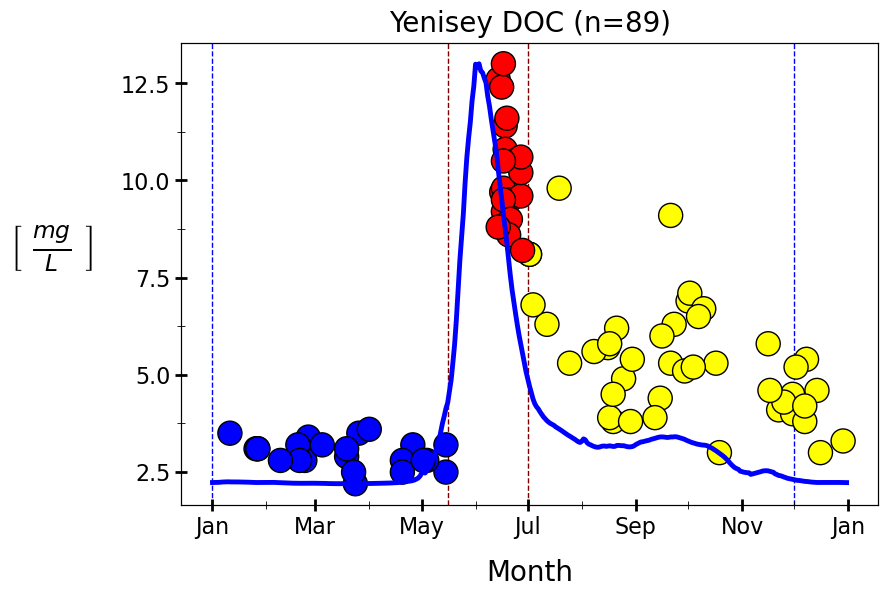

In [11]:
# Plot
fig, ax = plt.subplots(figsize=(9,6))

# Titles
ax.set_title(f'Yenisey DOC (n={dfc.shape[0]})', fontsize=20, c='black', pad=8)

# Data Points
ax.scatter(dfc['month_day'], dfc['DOC'], c=dfc['season'].map(colors), edgecolor='black', s=300, lw=1.0, ls='-', zorder=2)

# Labels (x)
ax.set_xlabel('Month', fontsize=20, c='black', labelpad=15)

# Labels (y)
ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)

# Second Axis: Discharge
ax1 = ax.twinx()

# Second Axis: Ticks
ax1.yaxis.set_ticks([])

# Second Axis: Plot
ax1.plot(dfq_daily.index, dfq_daily['q_m3/s'], c='blue', lw=3.5, ls='-', zorder=1)
#ax1.fill_between(dfq_daily.index, dfq_daily['lower_y'], dfq_daily['upper_y'], label="95% CI", color="deepskyblue", edgecolor="black", lw=1, alpha=1, ls='-', zorder=2)

ax.xaxis.set_major_formatter(month_name)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.axvline(pd.Timestamp('1900-01-01'), color='blue', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-05-16'), color='maroon', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-07-01'), color='maroon', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-07-01'), color='maroon', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-12-01'), color='blue', lw=1, ls='--', zorder=0)

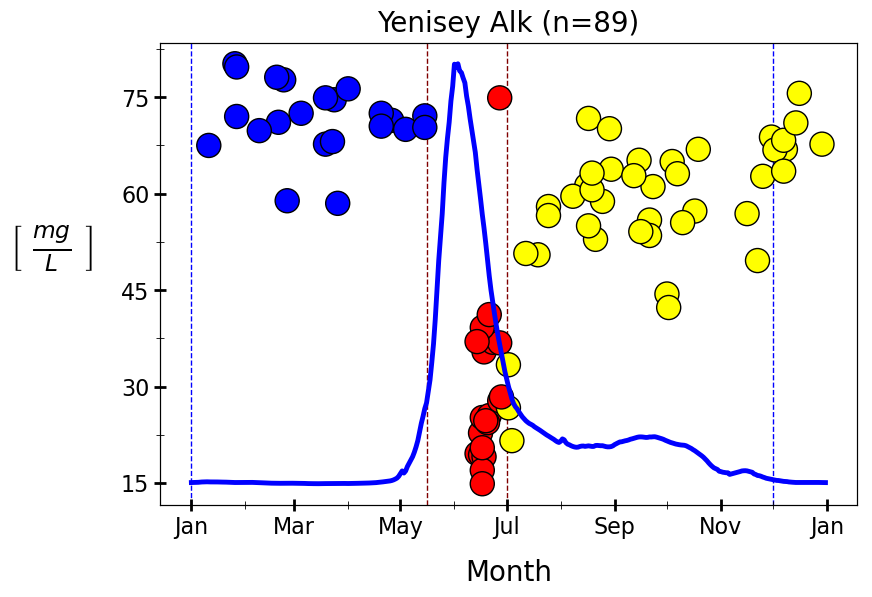

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(9,6))

# Titles
ax.set_title(f'Yenisey Alk (n={dfc.shape[0]})', fontsize=20, c='black', pad=8)

# Data Points
ax.scatter(dfc['month_day'], dfc['Alk'], c=dfc['season'].map(colors), edgecolor='black', s=300, lw=1.0, ls='-', zorder=2)

# Labels (x)
ax.set_xlabel('Month', fontsize=20, c='black', labelpad=15)

# Labels (y)
ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)

# Second Axis: Discharge
ax1 = ax.twinx()

# Second Axis: Ticks
ax1.yaxis.set_ticks([])

# Second Axis: Plot
ax1.plot(dfq_daily.index, dfq_daily['q_m3/s'], c='blue', lw=3.5, ls='-', zorder=1)
#ax1.fill_between(dfq_daily.index, dfq_daily['lower_y'], dfq_daily['upper_y'], label="95% CI", color="deepskyblue", edgecolor="black", lw=1, alpha=1, ls='-', zorder=2)

ax.xaxis.set_major_formatter(month_name)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.axvline(pd.Timestamp('1900-01-01'), color='blue', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-05-16'), color='maroon', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-07-01'), color='maroon', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-07-01'), color='maroon', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-12-01'), color='blue', lw=1, ls='--', zorder=0)

fig.savefig('AGRO_Yenisey_Regression_Alk_with_q.png', dpi=500, bbox_inches='tight')

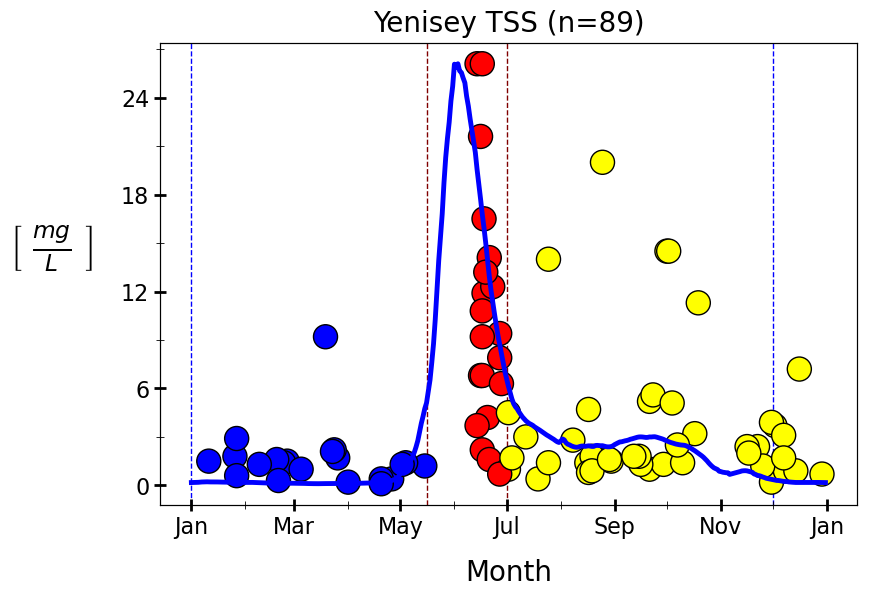

In [13]:
# Plot
fig, ax = plt.subplots(figsize=(9,6))

# Titles
ax.set_title(f'Yenisey TSS (n={dfc.shape[0]})', fontsize=20, c='black', pad=8)

# Data Points
ax.scatter(dfc['month_day'], dfc['TSS'], c=dfc['season'].map(colors), edgecolor='black', s=300, lw=1.0, ls='-', zorder=2)

# Labels (x)
ax.set_xlabel('Month', fontsize=20, c='black', labelpad=15)

# Labels (y)
ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)

# Second Axis: Discharge
ax1 = ax.twinx()

# Second Axis: Ticks
ax1.yaxis.set_ticks([])

# Second Axis: Plot
ax1.plot(dfq_daily.index, dfq_daily['q_m3/s'], c='blue', lw=3.5, ls='-', zorder=1)
#ax1.fill_between(dfq_daily.index, dfq_daily['lower_y'], dfq_daily['upper_y'], label="95% CI", color="deepskyblue", edgecolor="black", lw=1, alpha=1, ls='-', zorder=2)

ax.xaxis.set_major_formatter(month_name)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.axvline(pd.Timestamp('1900-01-01'), color='blue', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-05-16'), color='maroon', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-07-01'), color='maroon', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-07-01'), color='maroon', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-12-01'), color='blue', lw=1, ls='--', zorder=0)

<br><br><br>

# Solutes

<br><br><br>

<br><br><br>

#### TSS

<br><br><br>

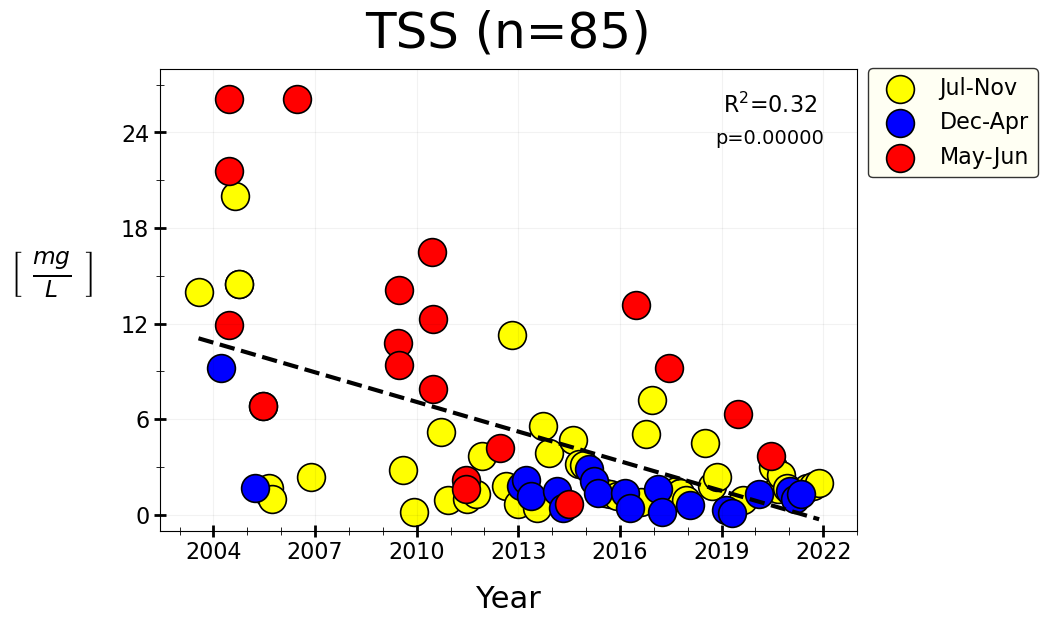

In [14]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="TSS", y_limits=(-1, 28))
fig.savefig('AGRO_Yenisey_Regression_TSS_legend.png', dpi=500, bbox_inches='tight')

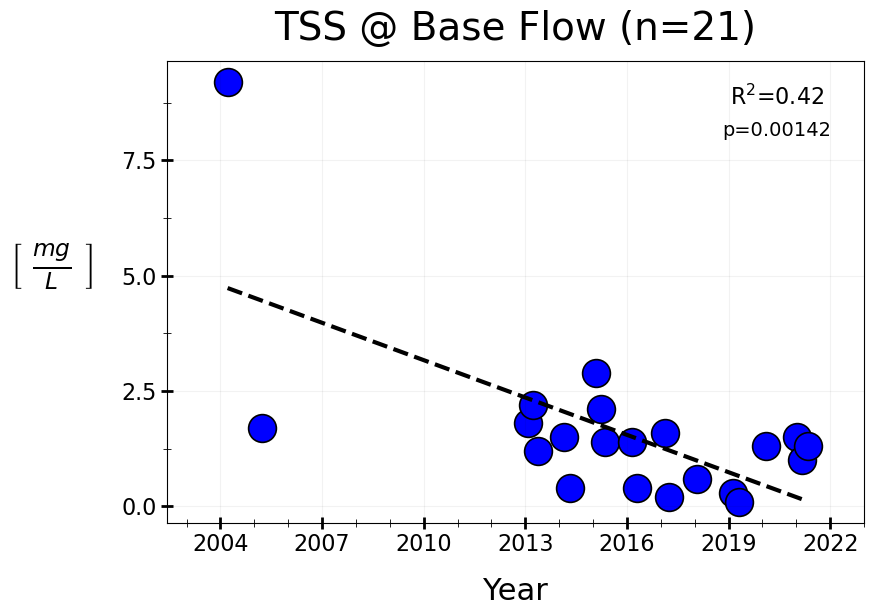

In [15]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="TSS")
fig.savefig('AGRO_Yenisey_Regression_TSS_Baseflow.png', dpi=500, bbox_inches='tight')

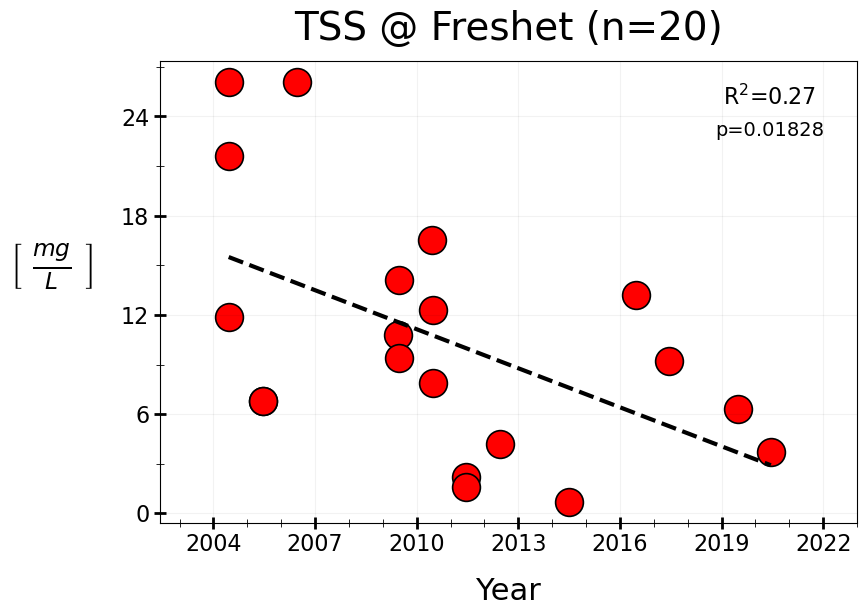

In [16]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="TSS")
fig.savefig('AGRO_Yenisey_Regression_TSS_Freshet.png', dpi=500, bbox_inches='tight')

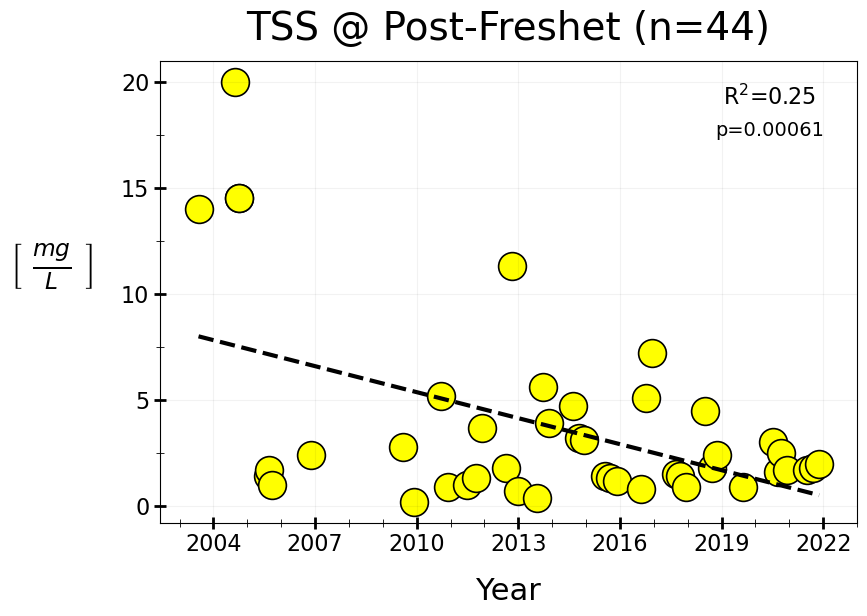

In [17]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df3, column_name="TSS")
fig.savefig('AGRO_Yenisey_Regression_TSS_Post_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

#### POC

<br><br><br>

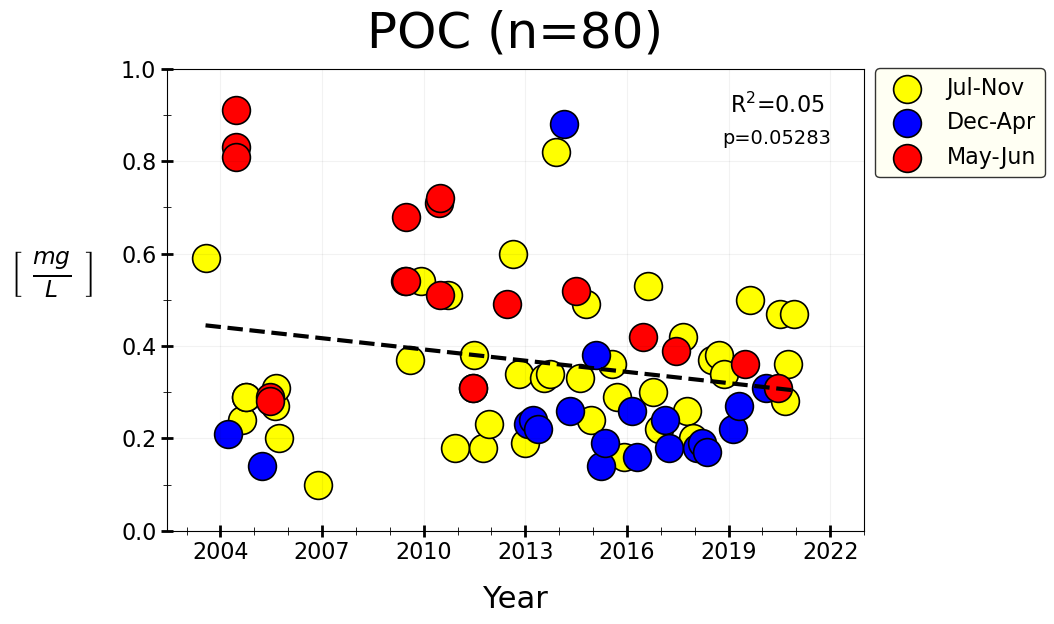

In [18]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="POC", y_limits=(0, 1))
fig.savefig('AGRO_Yenisey_Regression_POC_legend.png', dpi=500, bbox_inches='tight')

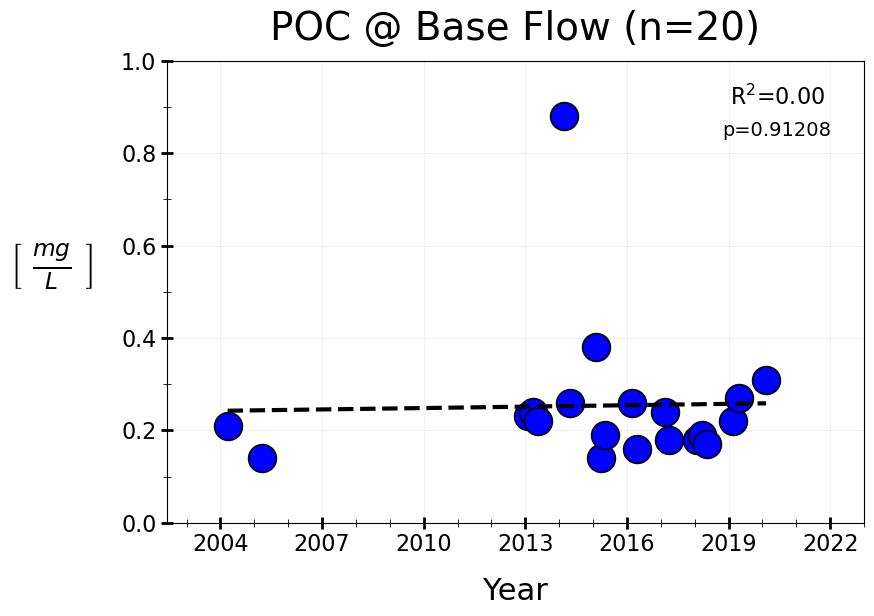

In [19]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="POC", y_limits=(0, 1))
fig.savefig('AGRO_Yenisey_Regression_POC_Baseflow.png', dpi=500, bbox_inches='tight')

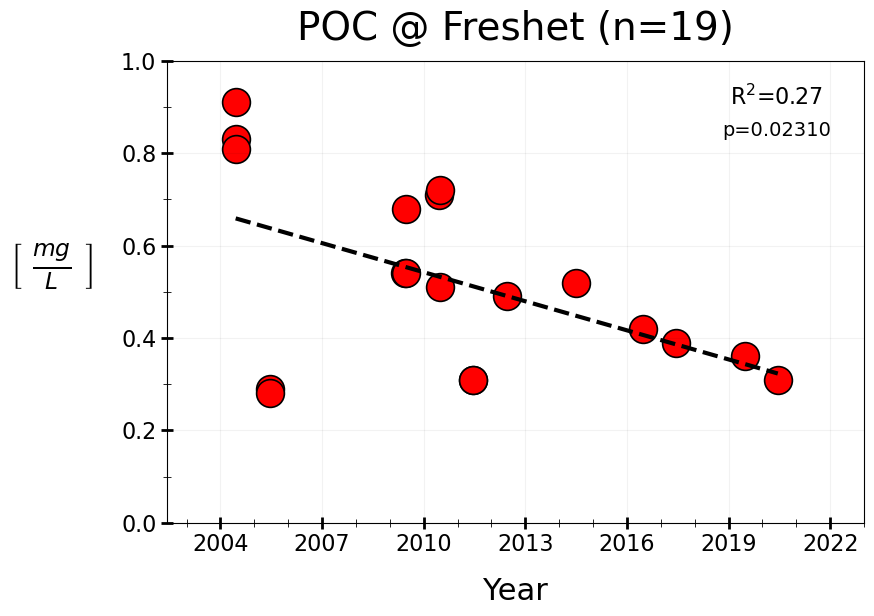

In [20]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="POC", y_limits=(0, 1))
fig.savefig('AGRO_Yenisey_Regression_PC_Freshet.png', dpi=500, bbox_inches='tight')

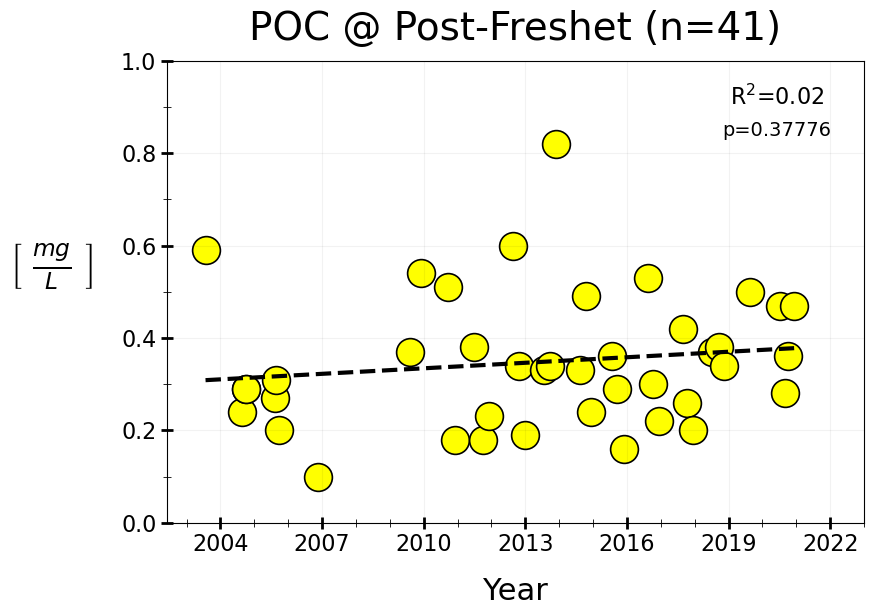

In [21]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df3, column_name="POC", y_limits=(0, 1))
#fig.savefig('AGRO_Yenisey_Regression_PC_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

#### DOC

<br><br><br>

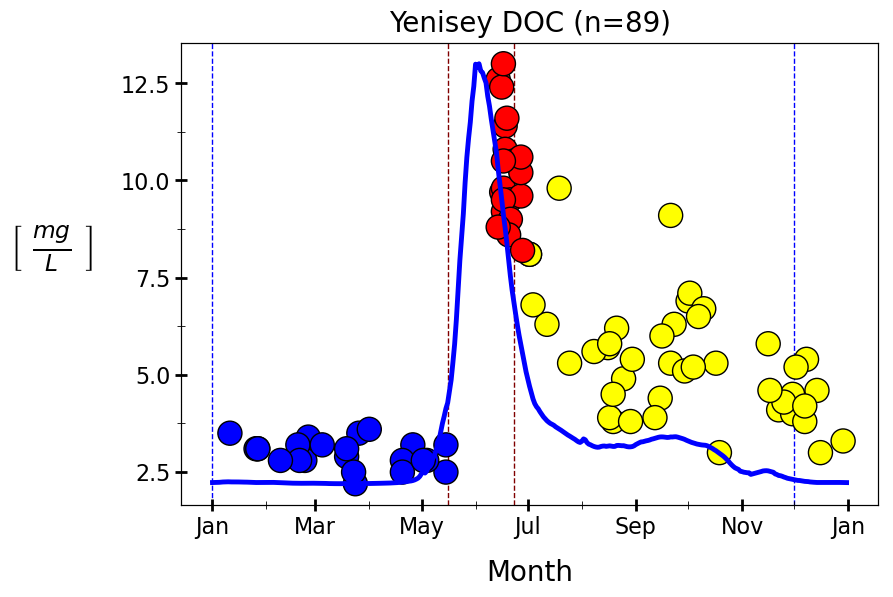

In [22]:
# Plot
fig, ax = plt.subplots(figsize=(9,6))

# Titles
ax.set_title(f'Yenisey DOC (n={dfc.shape[0]})', fontsize=20, c='black', pad=8)

# Data Points
ax.scatter(dfc['month_day'], dfc['DOC'], c=dfc['season'].map(colors), edgecolor='black', s=300, lw=1.0, ls='-', zorder=2)

# Labels (x)
ax.set_xlabel('Month', fontsize=20, c='black', labelpad=15)

# Labels (y)
ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)

# Second Axis: Discharge
ax1 = ax.twinx()

# Second Axis: Ticks
ax1.yaxis.set_ticks([])

# Second Axis: Plot
ax1.plot(dfq_daily.index, dfq_daily['q_m3/s'], c='blue', lw=3.5, ls='-', zorder=1)
#ax1.fill_between(dfq_daily.index, dfq_daily['lower_y'], dfq_daily['upper_y'], label="95% CI", color="deepskyblue", edgecolor="black", lw=1, alpha=1, ls='-', zorder=2)

ax.xaxis.set_major_formatter(month_name)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.axvline(pd.Timestamp('1900-01-01'), color='blue', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-05-16'), color='maroon', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-06-23'), color='maroon', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-07-01'), color='maroon', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-12-01'), color='blue', lw=1, ls='--', zorder=0)
fig.savefig('AGRO_Yenisey_Regression_DOC_with_q.png', dpi=500, bbox_inches='tight')

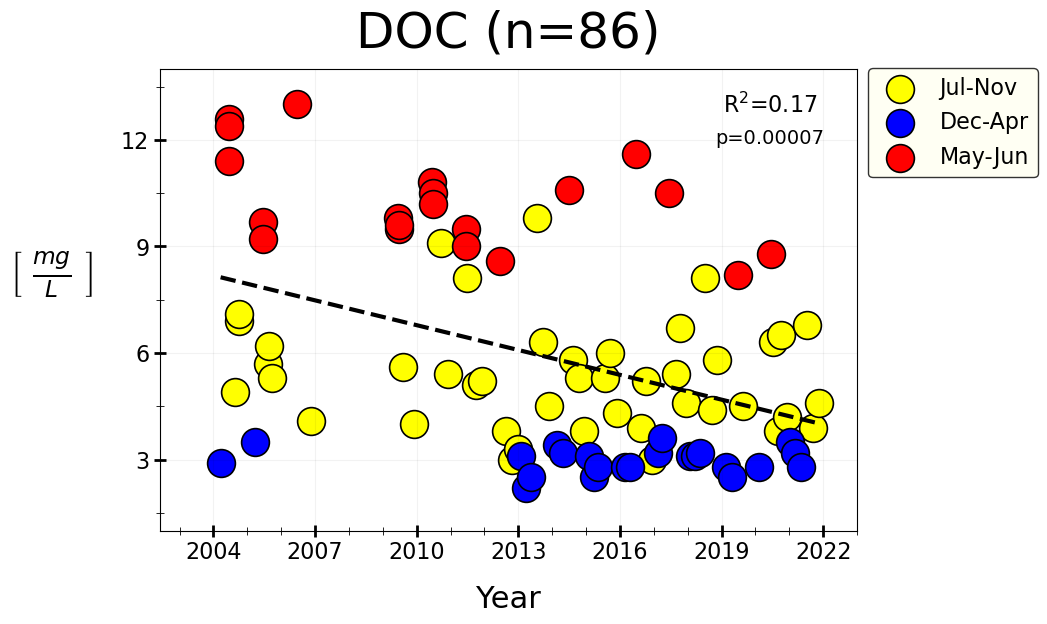

In [23]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="DOC", y_limits=(1,14))
fig.savefig('AGRO_Yenisey_Regression_DOC_legend.png', dpi=500, bbox_inches='tight')

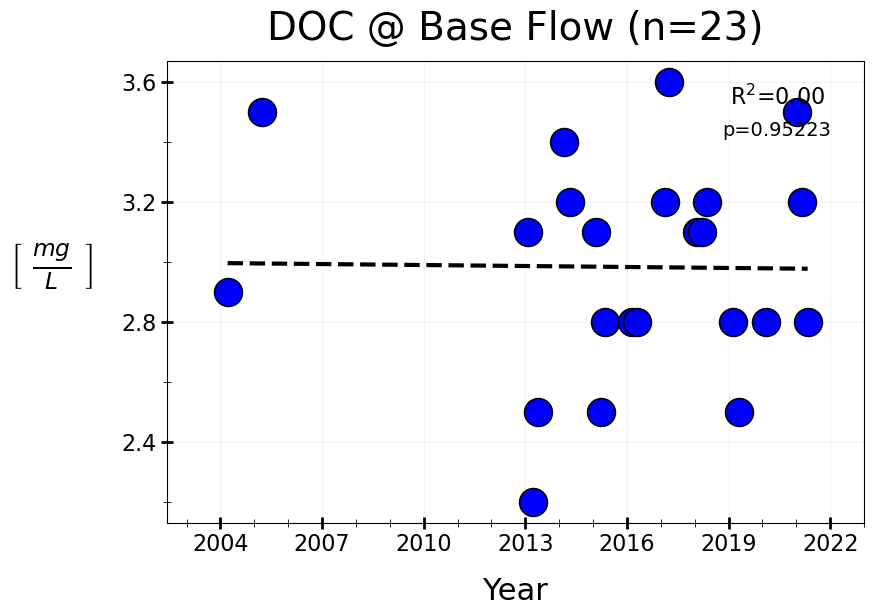

In [24]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="DOC")
fig.savefig('AGRO_Yenisey_Regression_DOC_Baseflow.png', dpi=500, bbox_inches='tight')

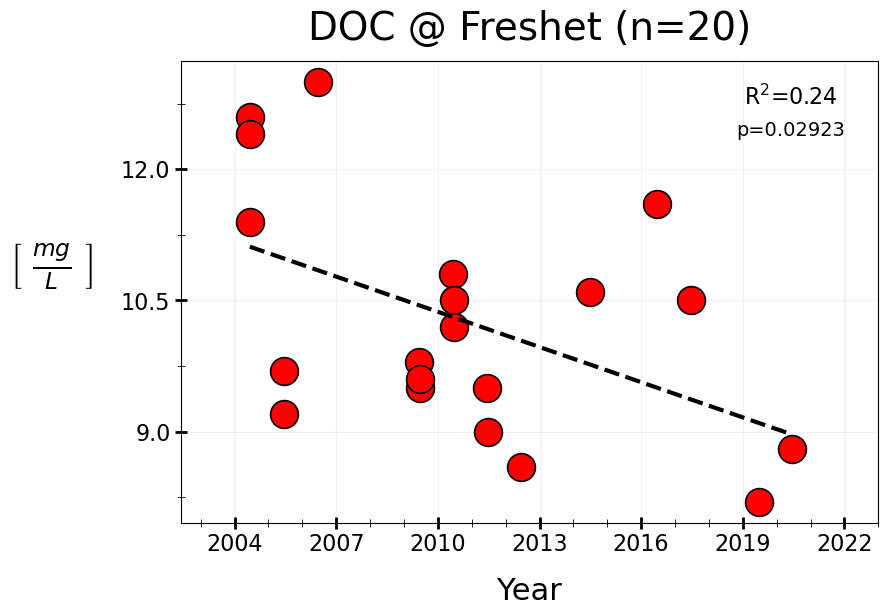

In [25]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="DOC")
fig.savefig('AGRO_Yenisey_Regression_DOC_Freshet.png', dpi=500, bbox_inches='tight')

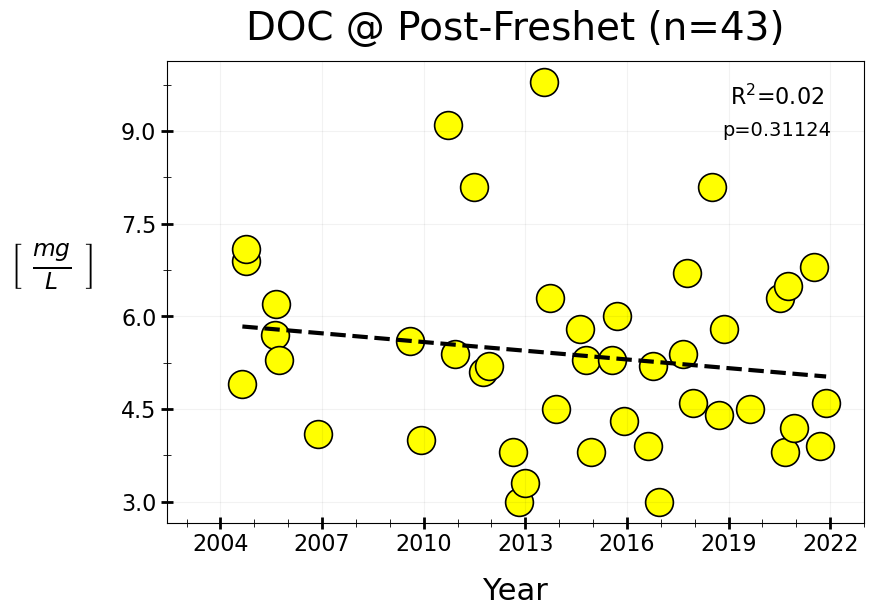

In [26]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df3, column_name="DOC")
fig.savefig('AGRO_Yenisey_Regression_DOC_Post_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

#### Alk

<br><br><br>

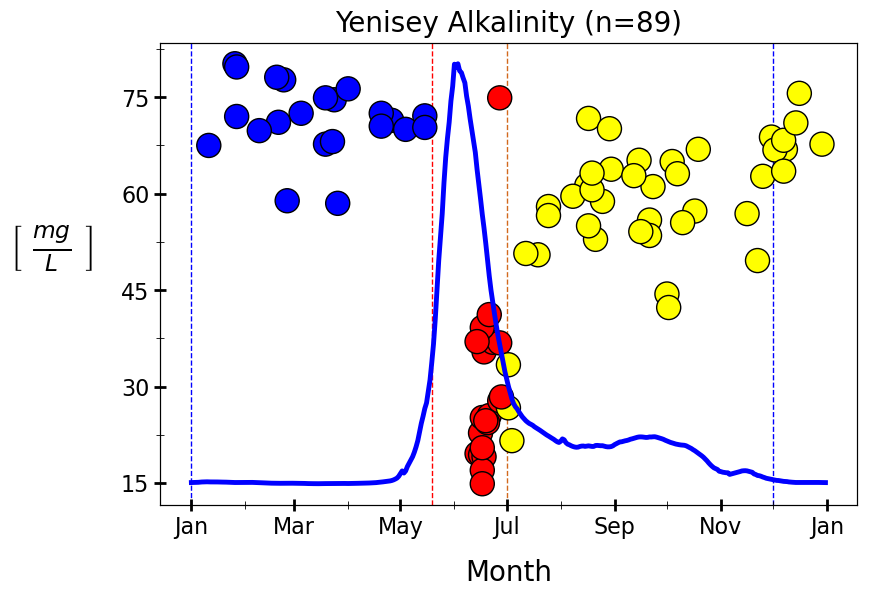

In [27]:
# Plot
fig, ax = plt.subplots(figsize=(9,6))

# Titles
ax.set_title(f'Yenisey Alkalinity (n={dfc.shape[0]})', fontsize=20, c='black', pad=8)

# Data Points
ax.scatter(dfc['month_day'], dfc['Alk'], c=dfc['season'].map(colors), edgecolor='black', s=300, lw=1.0, ls='-', zorder=2)

# Labels (x)
ax.set_xlabel('Month', fontsize=20, c='black', labelpad=15)

# Labels (y)
ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)

# Second Axis: Discharge
ax1 = ax.twinx()

# Second Axis: Ticks
ax1.yaxis.set_ticks([])

# Second Axis: Plot
ax1.plot(dfq_daily.index, dfq_daily['q_m3/s'], c='blue', lw=3.5, ls='-', zorder=1)
#ax1.fill_between(dfq_daily.index, dfq_daily['lower_y'], dfq_daily['upper_y'], label="95% CI", color="deepskyblue", edgecolor="black", lw=1, alpha=1, ls='-', zorder=2)

ax.xaxis.set_major_formatter(month_name)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
#ax.axvline(pd.Timestamp('1900-03-21'), color='green', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-06-21'), color='red', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-09-21'), color='chocolate', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-12-21'), color='blue', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-01-01'), color='blue', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-05-19'), color='red', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-07-01'), color='chocolate', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-12-01'), color='blue', lw=1, ls='--', zorder=0)

#fig.suptitle('Siberian Rivers (2003-2021)', fontsize=32, x=0.58, y=1.005)

#fig.savefig('AGRO_Daily_T_Month_Day.png', dpi = 500, bbox_inches='tight')

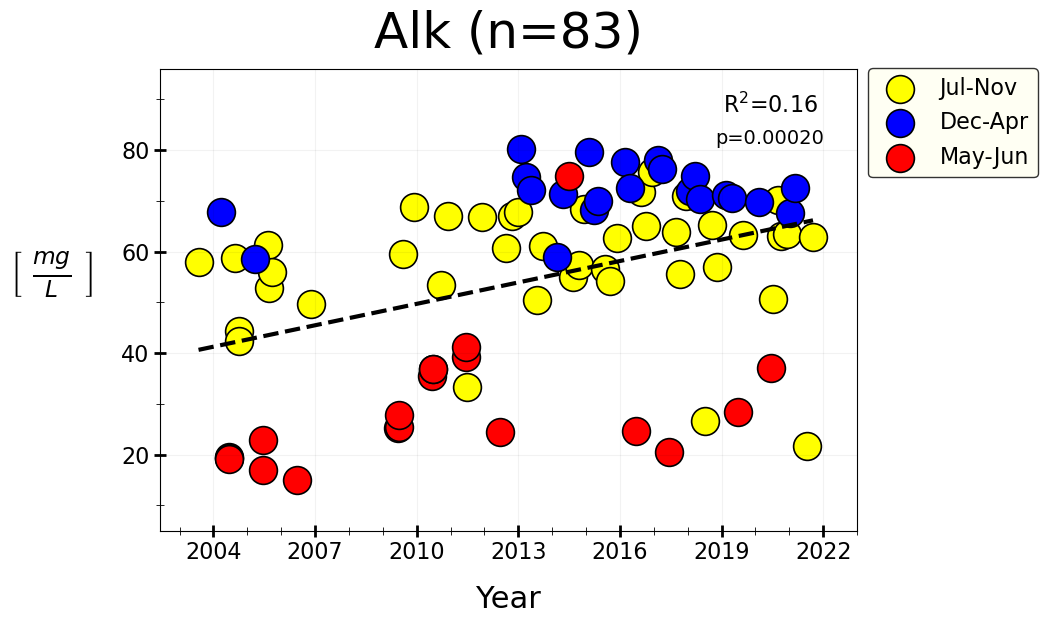

In [28]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="Alk", y_limits=(5,96))
fig.savefig('AGRO_Yenisey_Regression_Alk_legend.png', dpi=500, bbox_inches='tight')

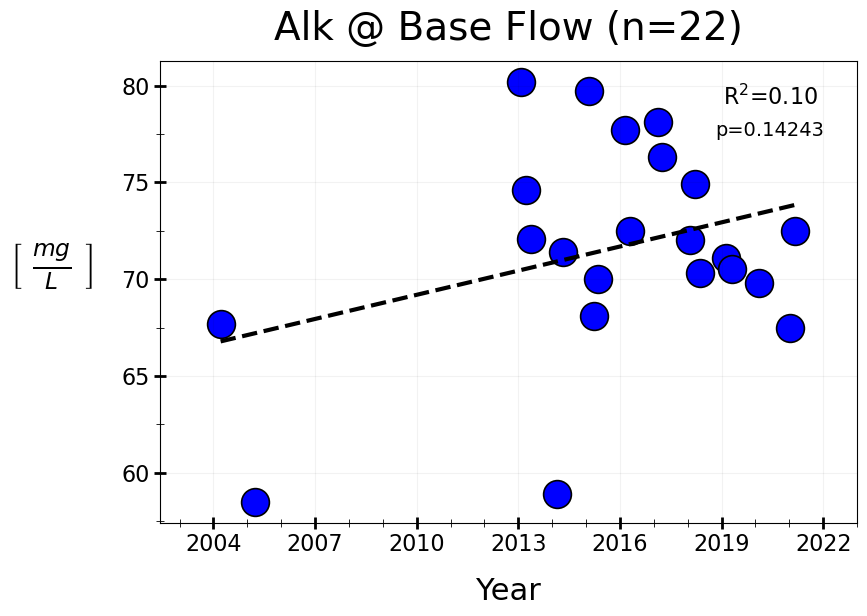

In [29]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="Alk")
fig.savefig('AGRO_Yenisey_Regression_Alk_Baseflow.png', dpi=500, bbox_inches='tight')

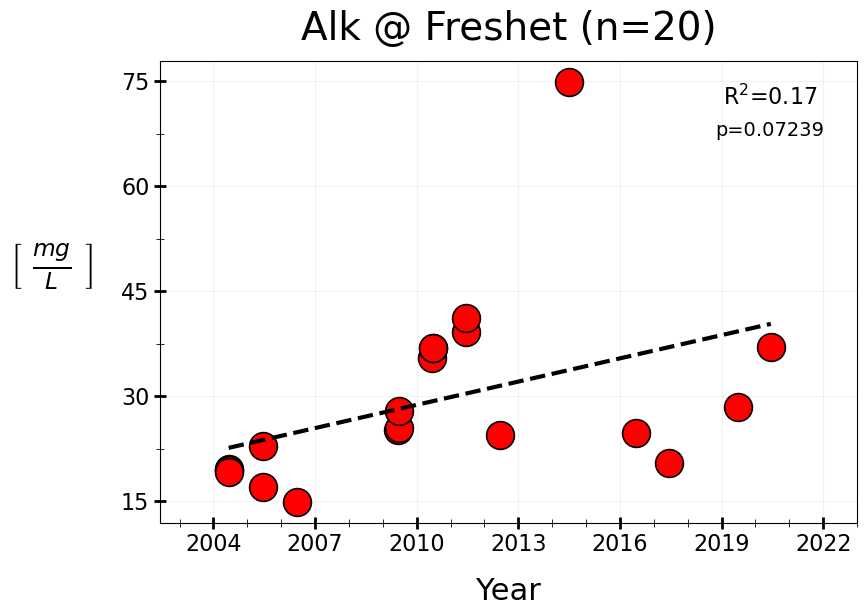

In [30]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="Alk")
fig.savefig('AGRO_Yenisey_Regression_Alk_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

#### Ca

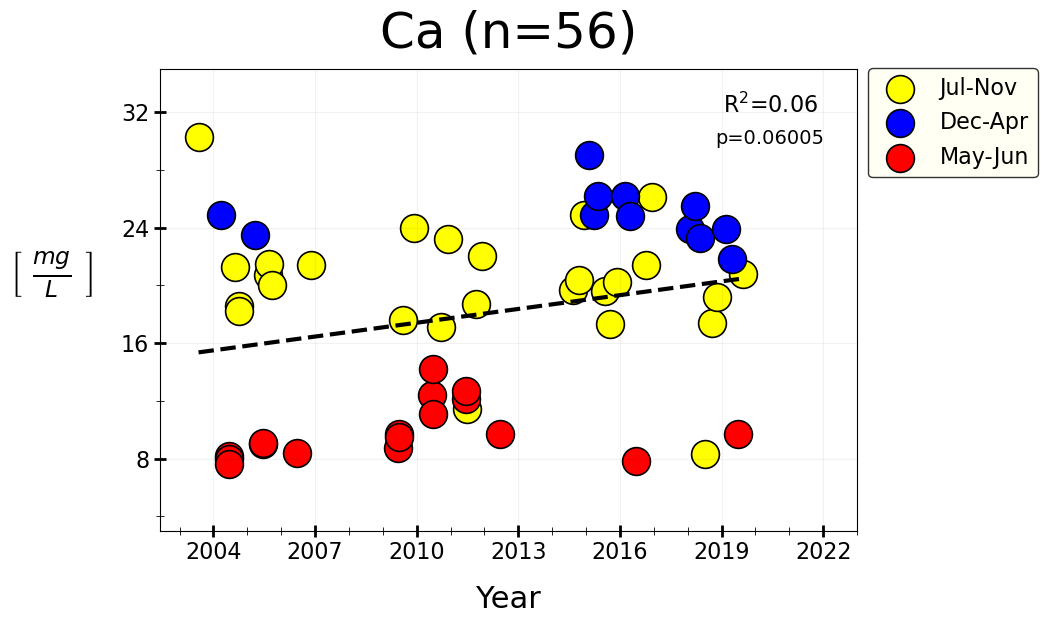

In [31]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="Ca", y_limits=(3,35))
fig.savefig('AGRO_Yenisey_Regression_Ca_legend.png', dpi=500, bbox_inches='tight')

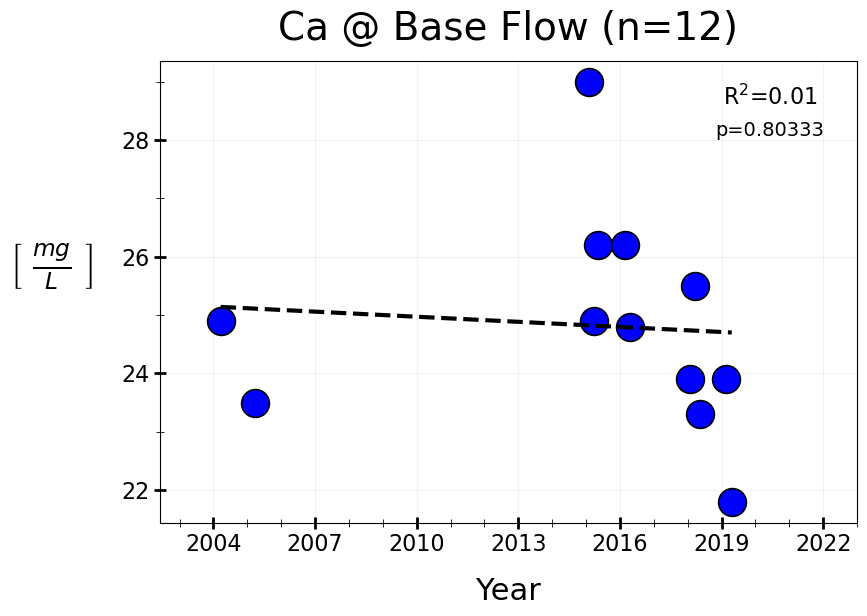

In [32]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="Ca")
fig.savefig('AGRO_Yenisey_Regression_Ca_Baseflow.png', dpi=500, bbox_inches='tight')

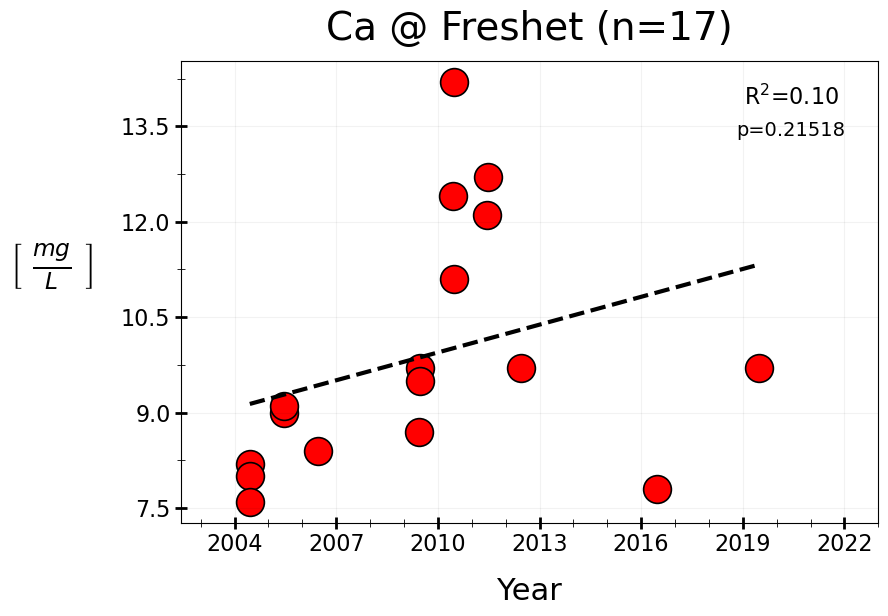

In [33]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="Ca")
fig.savefig('AGRO_Yenisey_Regression_Ca_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

#### Mg

<br><br><br>

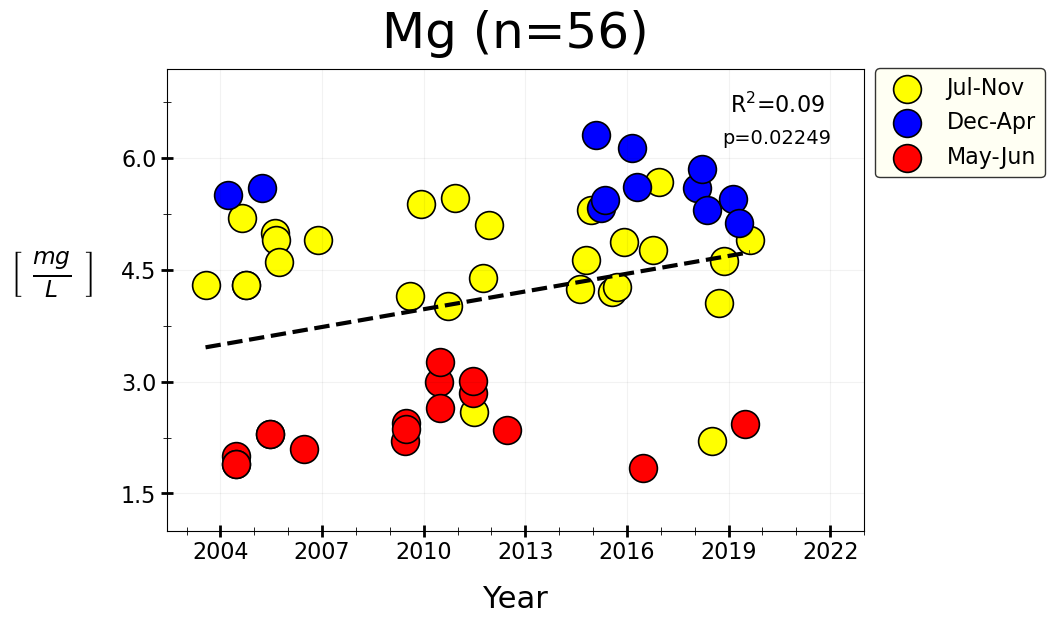

In [34]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="Mg", y_limits=(1.0, 7.2))
fig.savefig('AGRO_Yenisey_Regression_Mg_legend.png', dpi=500, bbox_inches='tight')

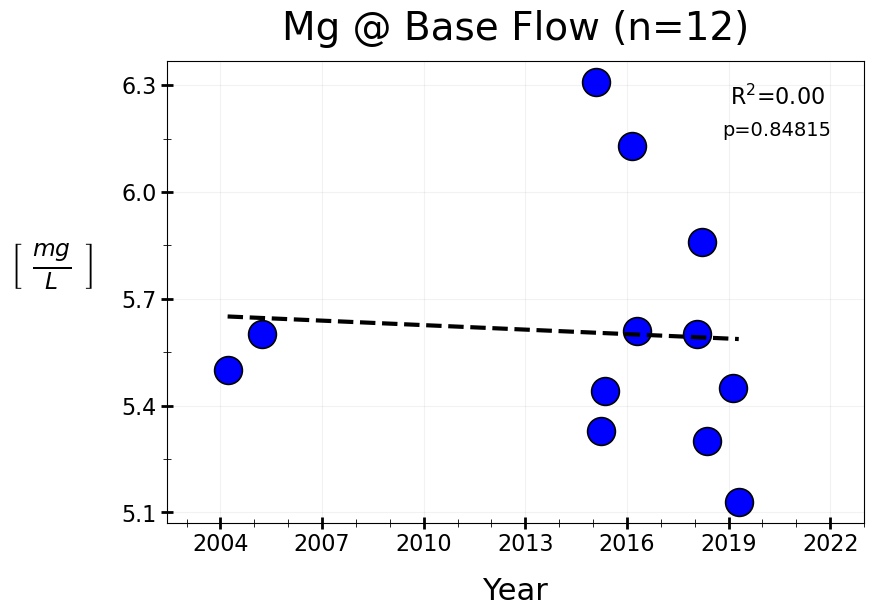

In [35]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="Mg")
#fig.savefig('AGRO_Yenisey_Regression_Mg_Baseflow.png', dpi=500, bbox_inches='tight')

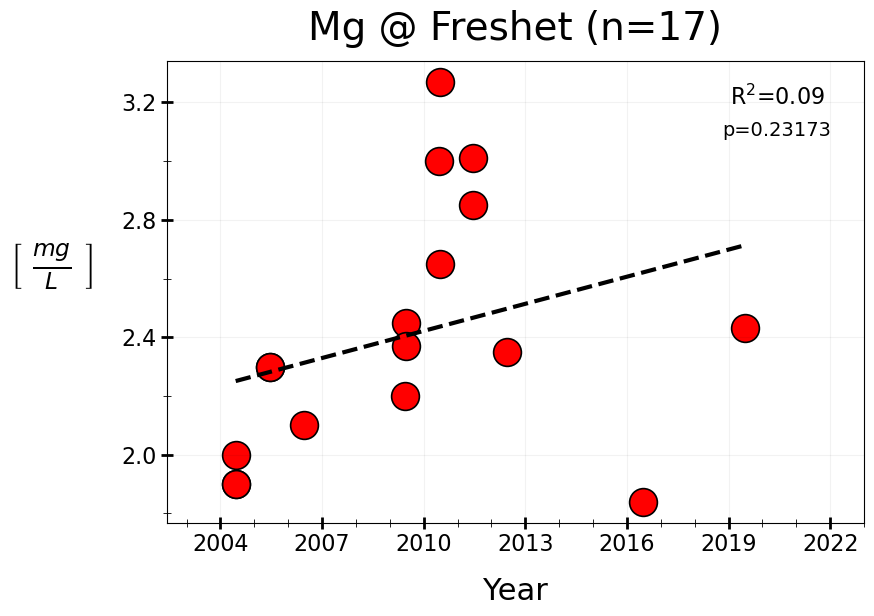

In [36]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="Mg")
#fig.savefig('AGRO_Yenisey_Regression_Mg_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

#### Na

<br><br><br>

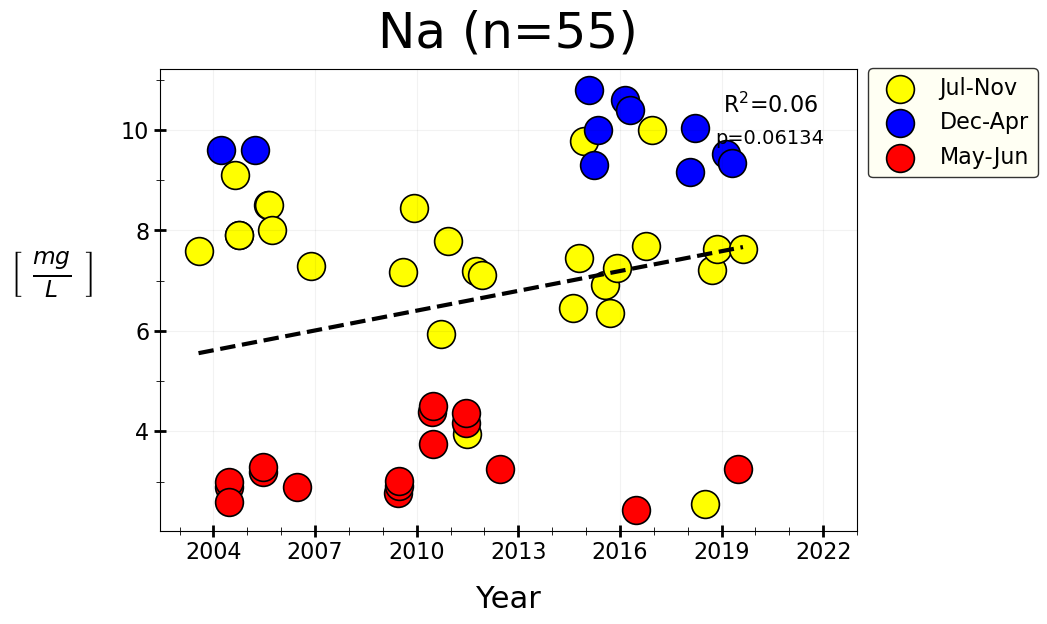

In [37]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="Na") #y_limits=(1.0, 7.2)
#fig.savefig('AGRO_Yenisey_Regression_Na_legend.png', dpi=500, bbox_inches='tight')

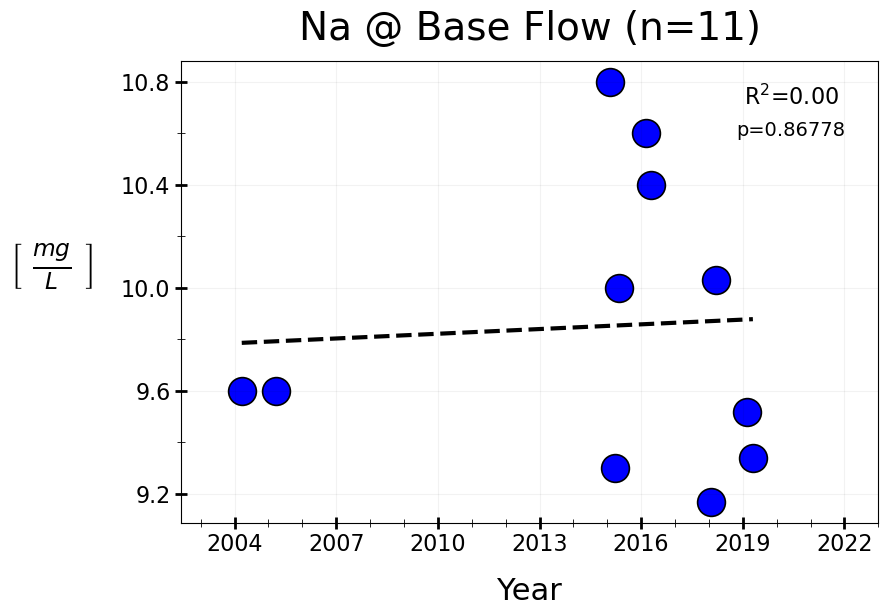

In [38]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="Na")
#fig.savefig('AGRO_Yenisey_Regression_Na_Baseflow.png', dpi=500, bbox_inches='tight')

<br><br><br>

#### PON

<br><br><br>

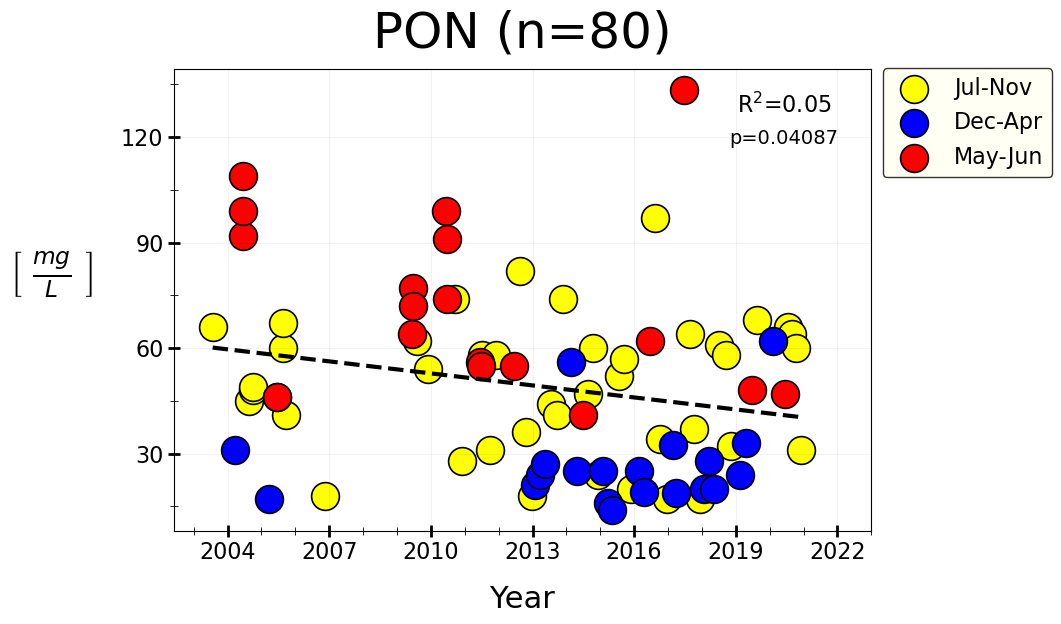

In [39]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="PON")
#fig.savefig('AGRO_Yenisey_Regression_PON_legend.png', dpi=500, bbox_inches='tight')

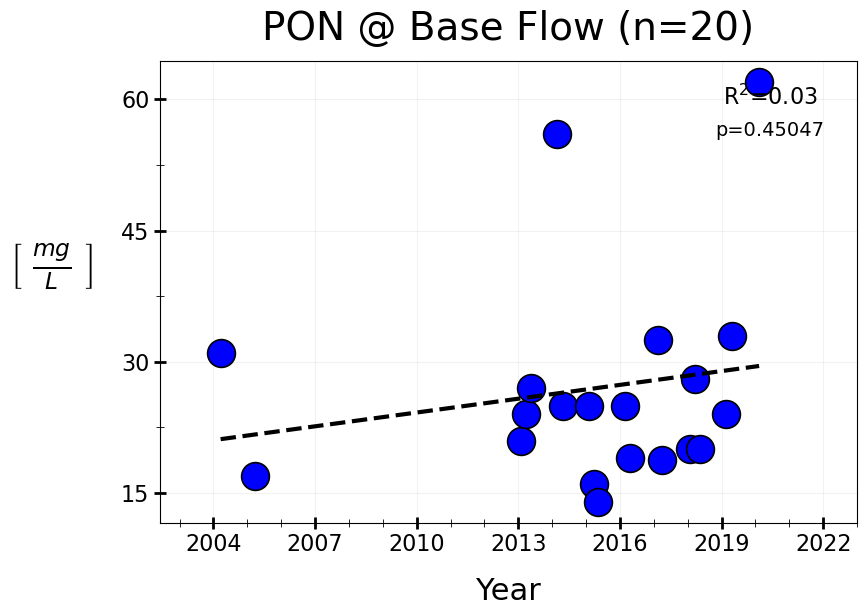

In [40]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="PON")
#fig.savefig('AGRO_Yenisey_Regression_PON_Baseflow.png', dpi=500, bbox_inches='tight')

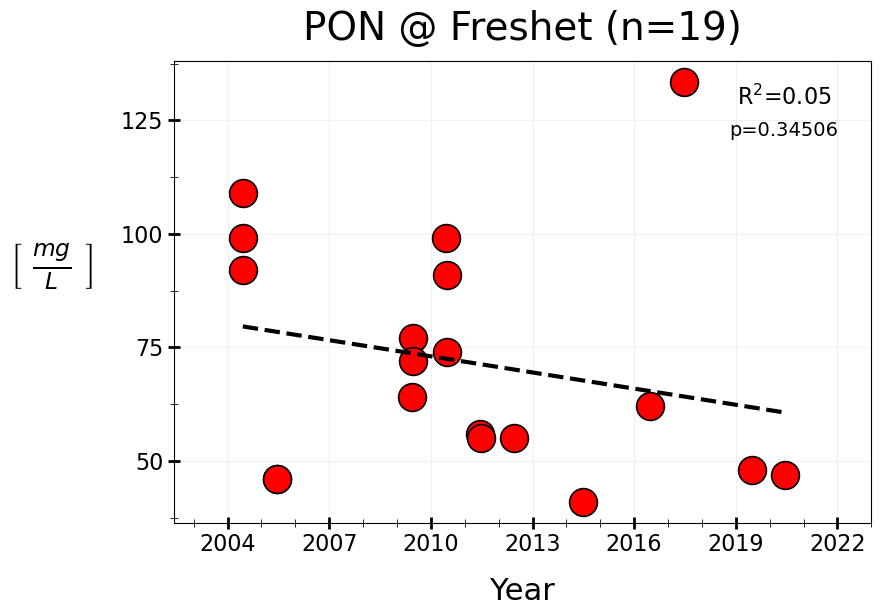

In [41]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="PON")
#fig.savefig('AGRO_Yenisey_Regression_PON_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

#### TDN

<br><br><br>

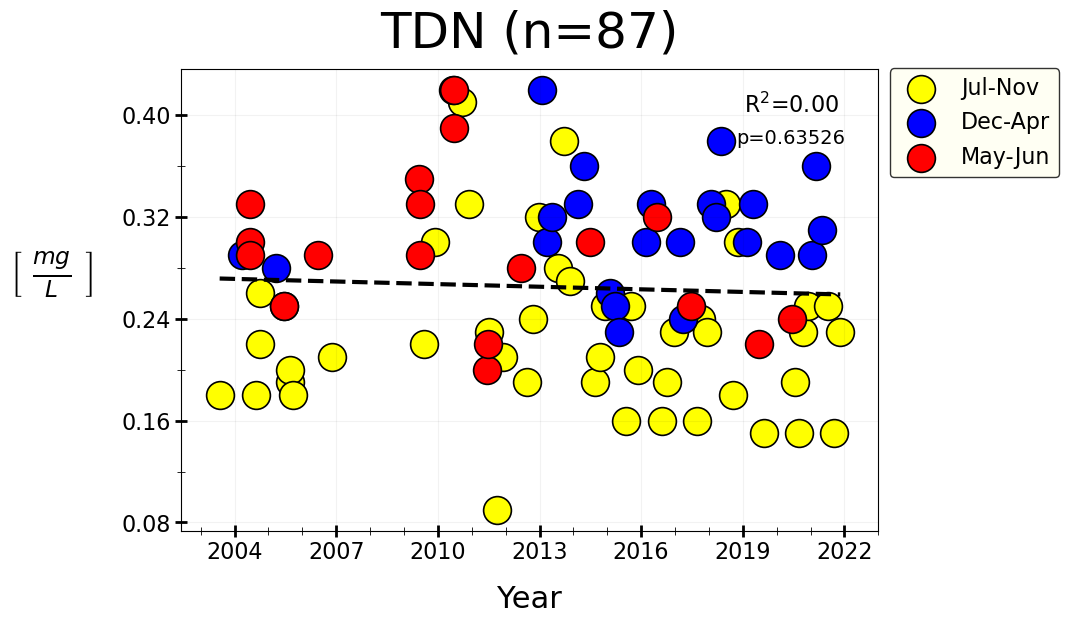

In [42]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="TDN")
#fig.savefig('AGRO_Yenisey_Regression_TDN_legend.png', dpi=500, bbox_inches='tight')

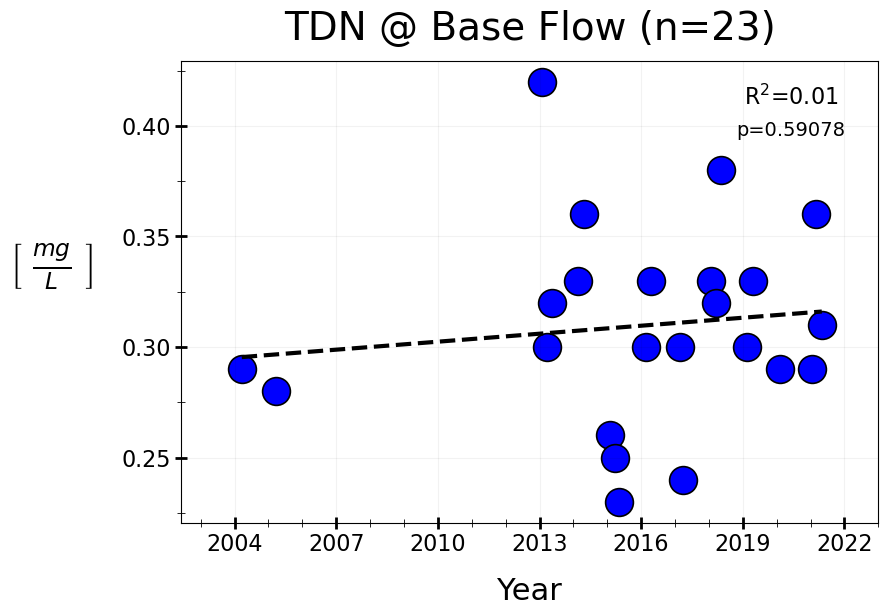

In [43]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="TDN")
#fig.savefig('AGRO_Yenisey_Regression_TDN_Baseflow.png', dpi=500, bbox_inches='tight')

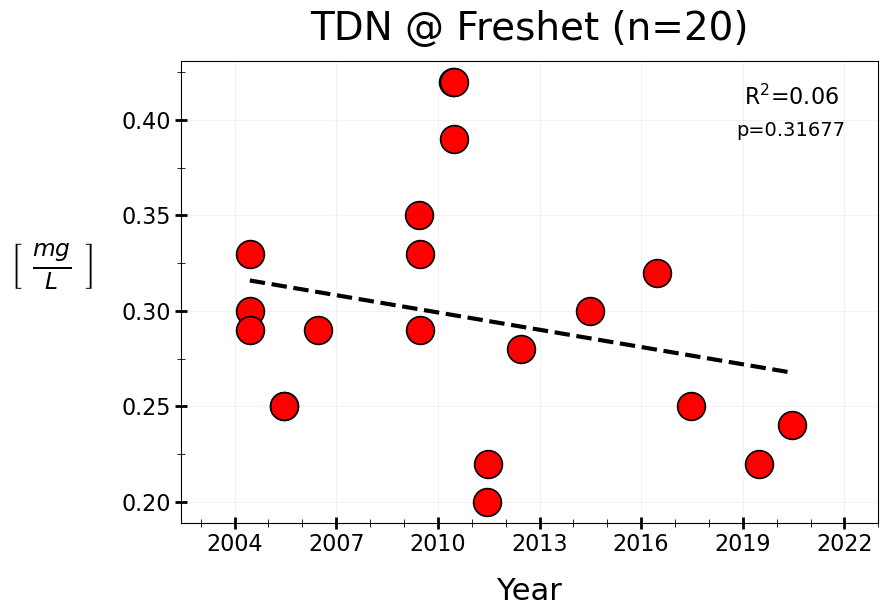

In [44]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="TDN")
#fig.savefig('AGRO_Yenisey_Regression_TDN_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

#### TDP

<br><br><br>

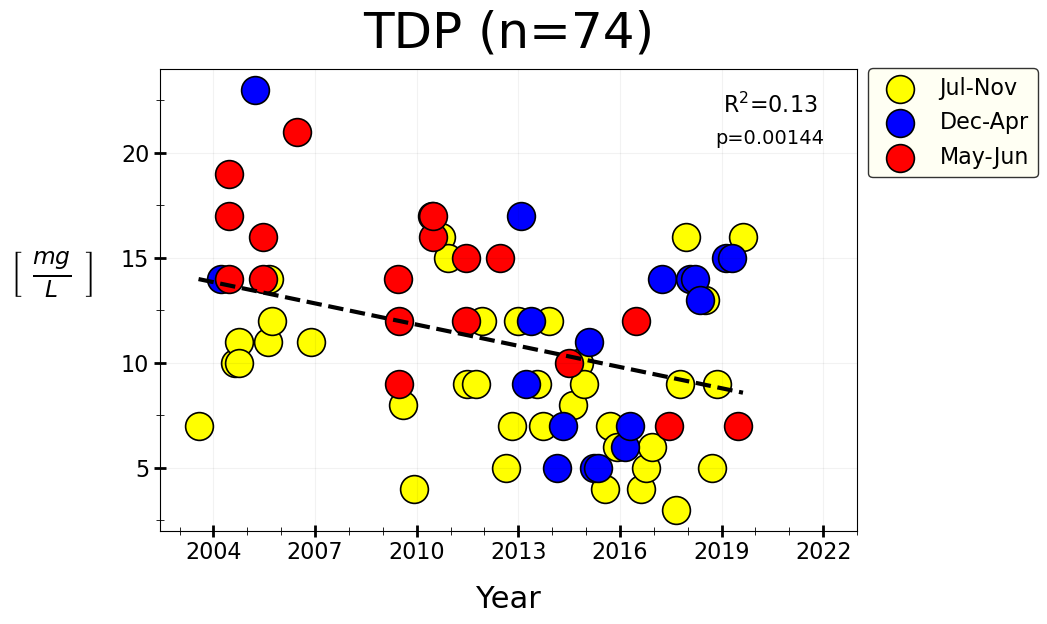

In [45]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="TDP")
fig.savefig('AGRO_Yenisey_Regression_TDP_legend.png', dpi=500, bbox_inches='tight')

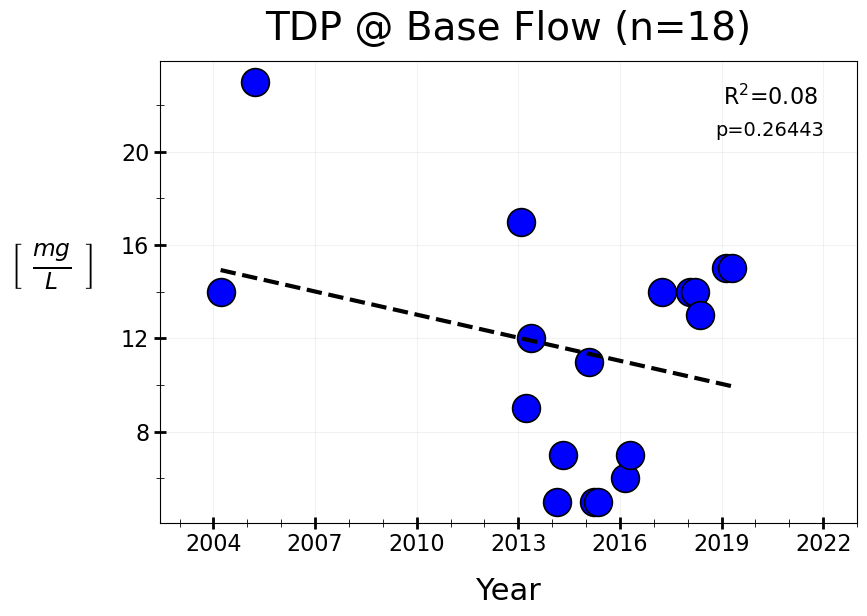

In [46]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="TDP")
fig.savefig('AGRO_Yenisey_Regression_TDP_Baseflow.png', dpi=500, bbox_inches='tight')

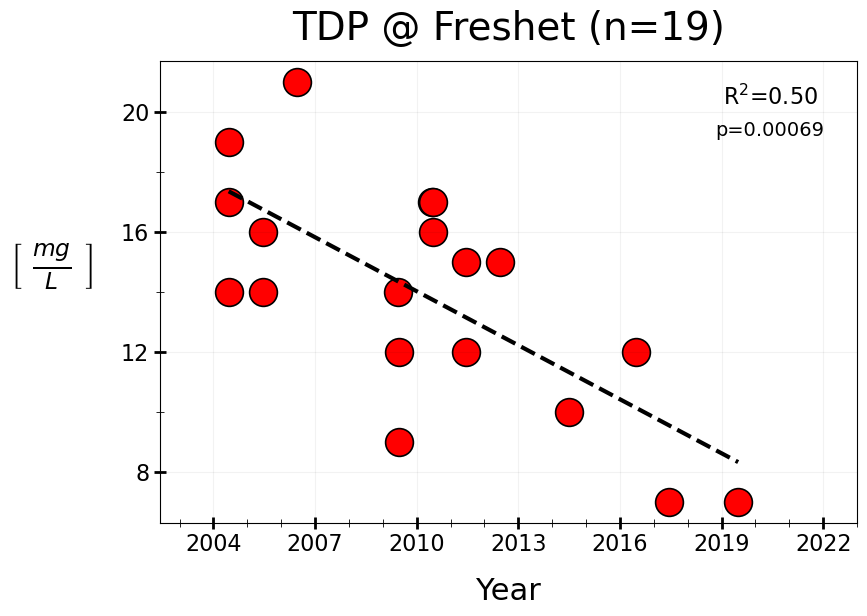

In [47]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="TDP")
fig.savefig('AGRO_Yenisey_Regression_TDP_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

### Ca + Mg / Alk

<br><br><br>

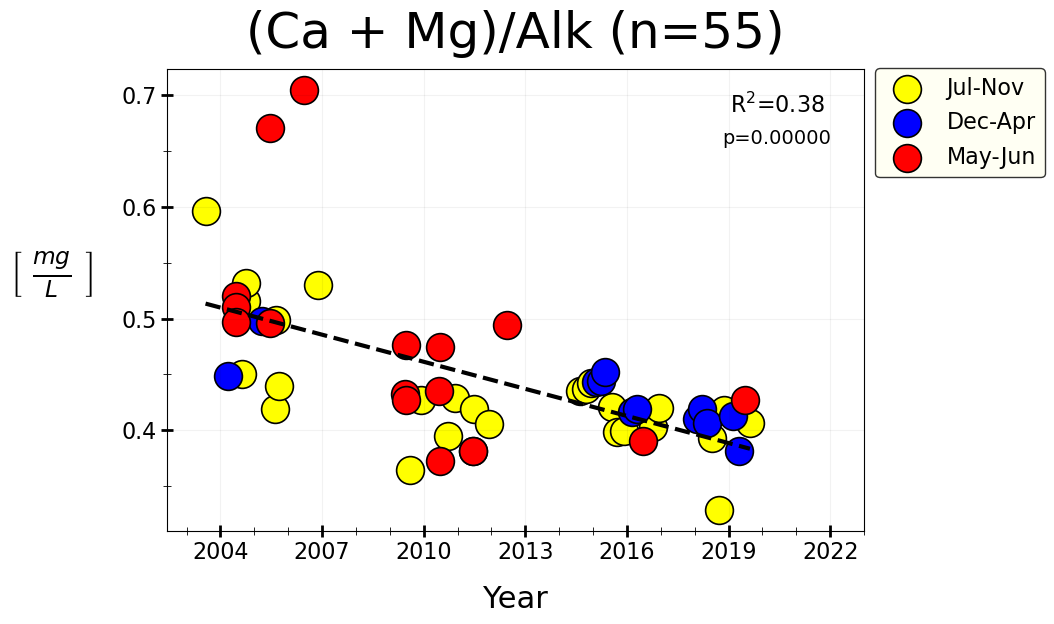

In [48]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="(Ca + Mg)/Alk")
fig.savefig('AGRO_Yenisey_Regression_CaMg_Alk_legend.png', dpi=500, bbox_inches='tight')

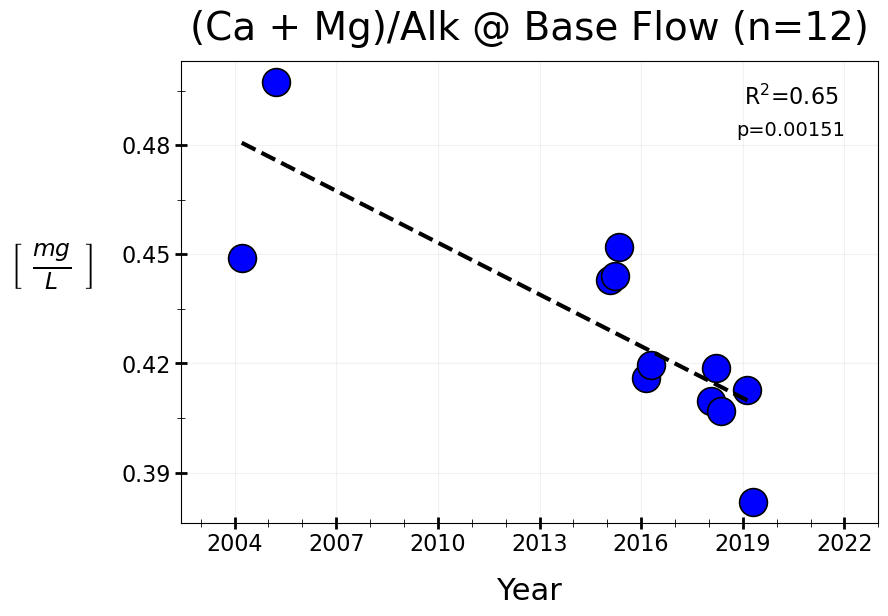

In [49]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="(Ca + Mg)/Alk")
fig.savefig('AGRO_Yenisey_Regression_camg_alk_Baseflow.png', dpi=500, bbox_inches='tight')

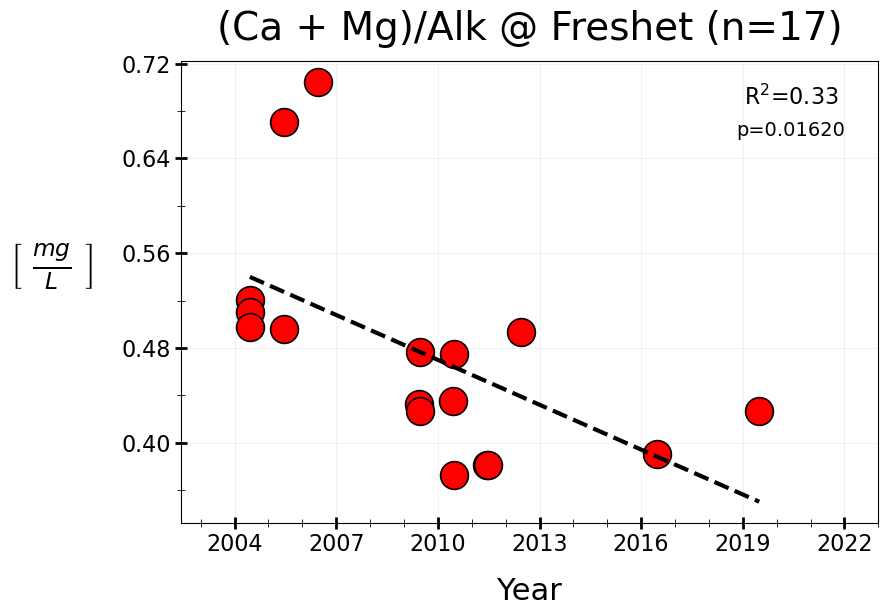

In [50]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="(Ca + Mg)/Alk")
fig.savefig('AGRO_Yenisey_Regression_camg_alk_Freshet.png', dpi=500, bbox_inches='tight')

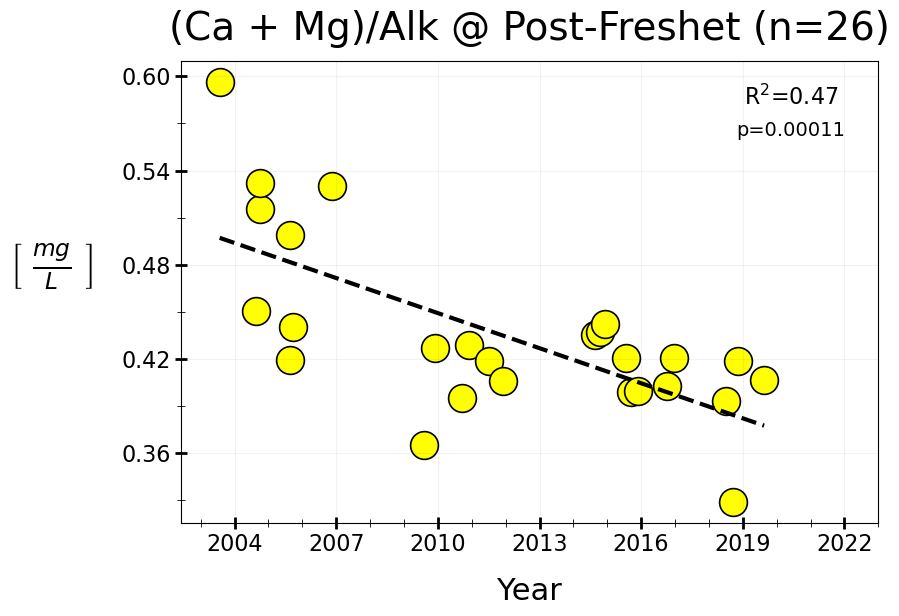

In [51]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df3, column_name="(Ca + Mg)/Alk")
fig.savefig('AGRO_Yenisey_Regression_camg_alk_Post_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

### Cl/Na

<br><br><br>

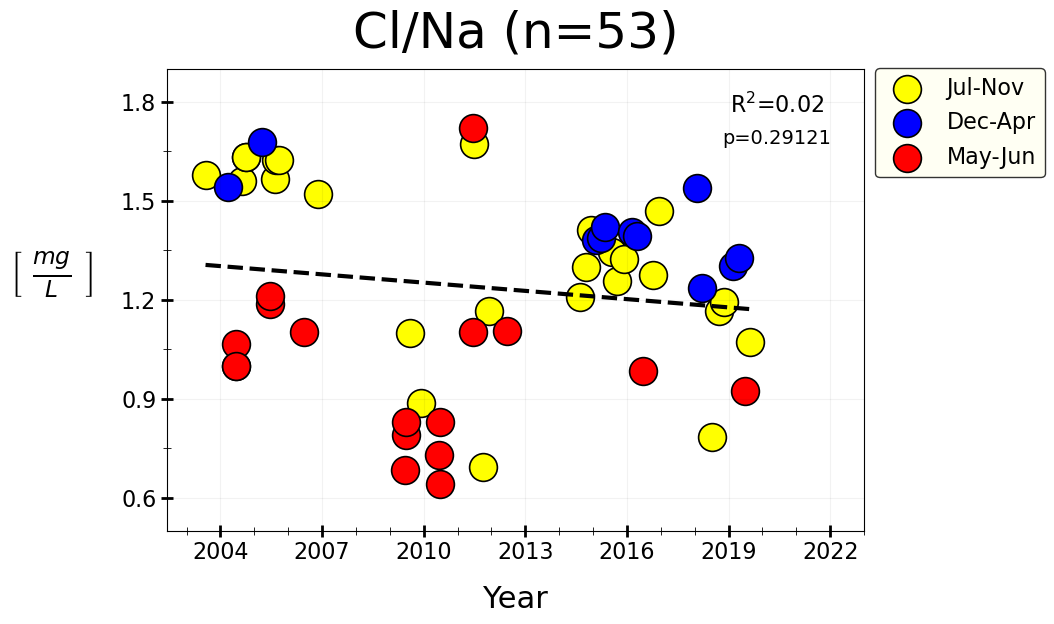

In [52]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="Cl/Na", y_limits=(0.5, 1.9))
#fig.savefig('AGRO_Yenisey_Regression_ClNa_legend.png', dpi=500, bbox_inches='tight')

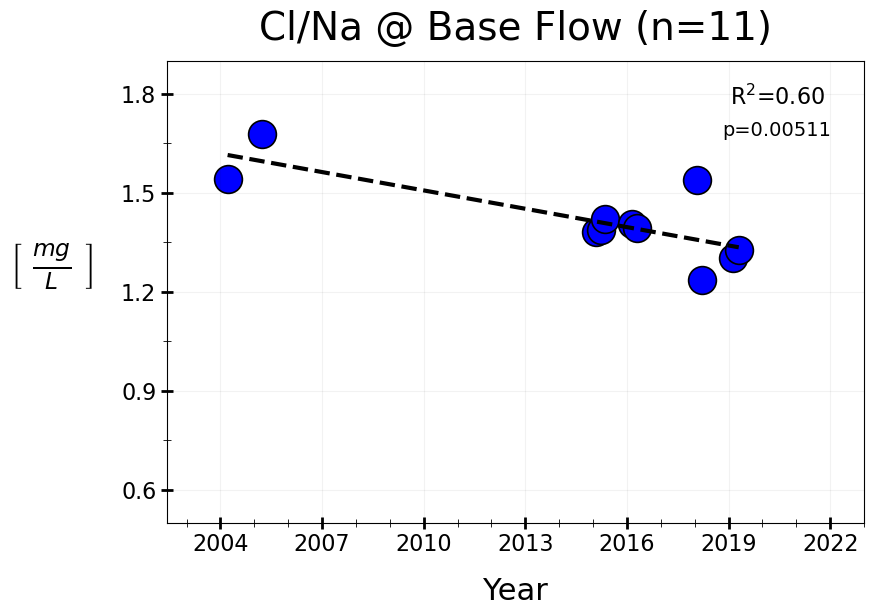

In [53]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="Cl/Na", y_limits=(0.5, 1.9))
#fig.savefig('AGRO_Yenisey_Regression_ClNa_Baseflow.png', dpi=500, bbox_inches='tight')

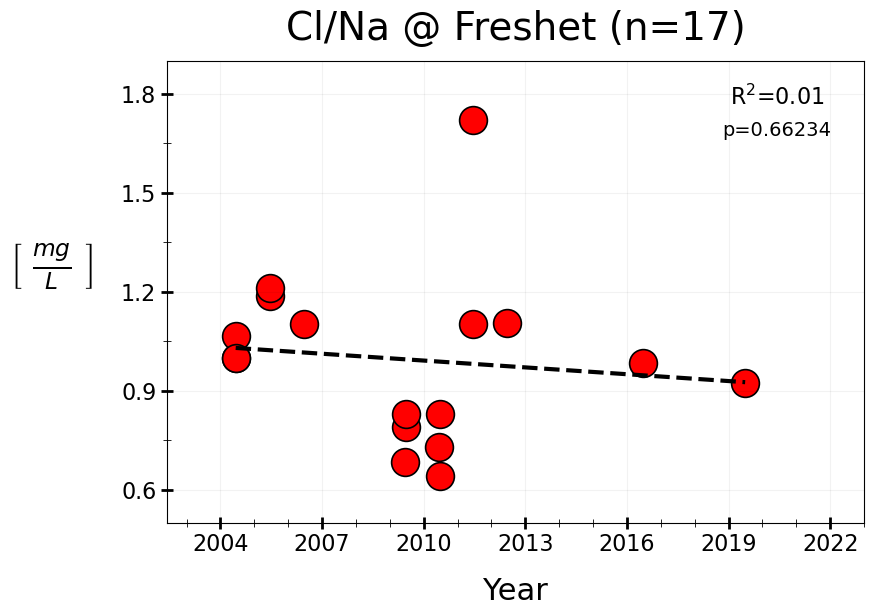

In [54]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="Cl/Na", y_limits=(0.5, 1.9))
#fig.savefig('AGRO_Yenisey_Regression_ClNa_Freshet.png', dpi=500, bbox_inches='tight')

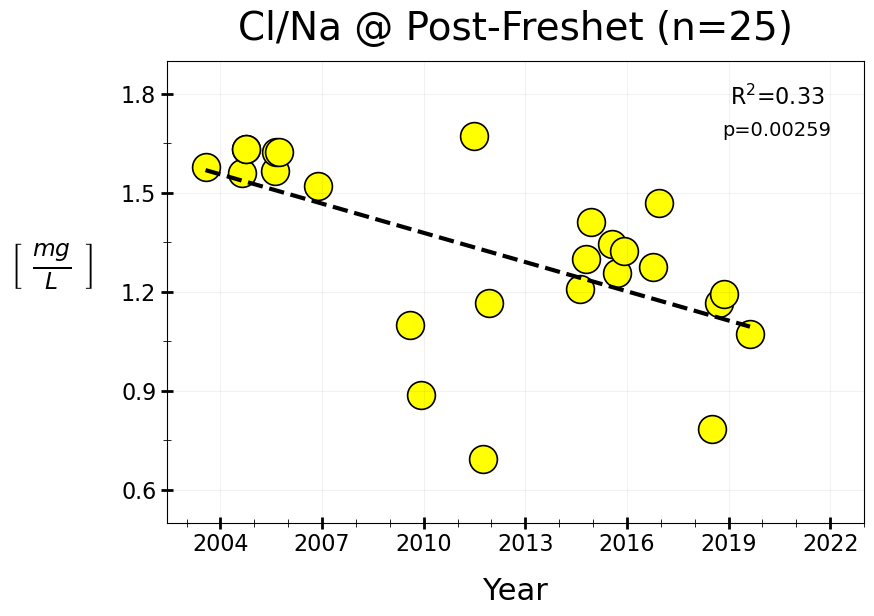

In [55]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df3, column_name="Cl/Na", y_limits=(0.5, 1.9))
#fig.savefig('AGRO_Yenisey_Regression_ClNa_Post_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

### Mg/Na

<br><br><br>

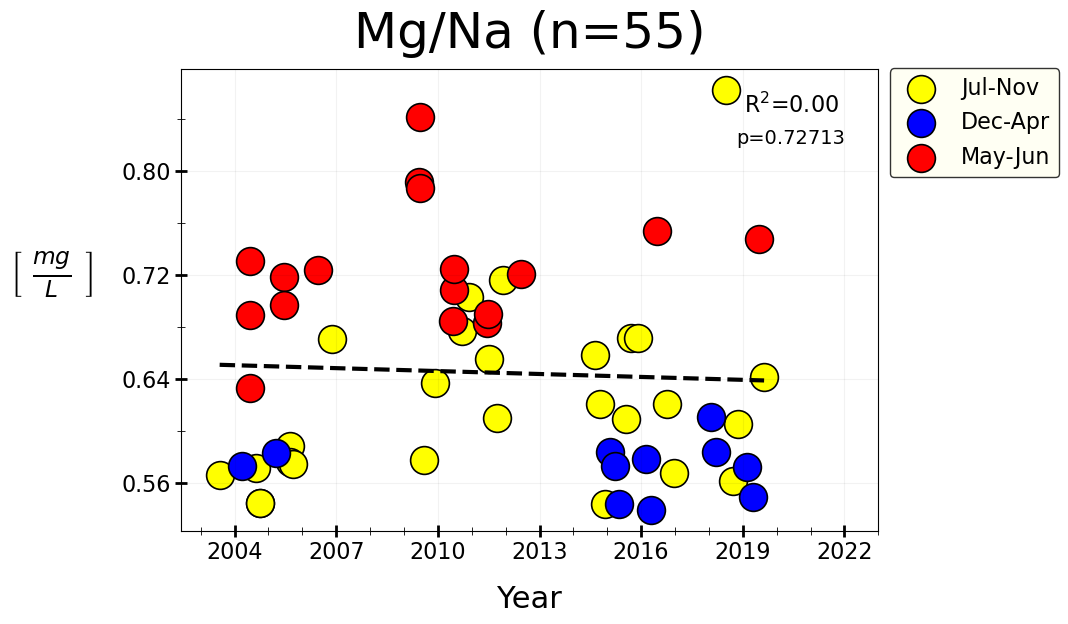

In [56]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="Mg/Na")
#fig.savefig('AGRO_Yenisey_Regression_MgNa_legend.png', dpi=500, bbox_inches='tight')

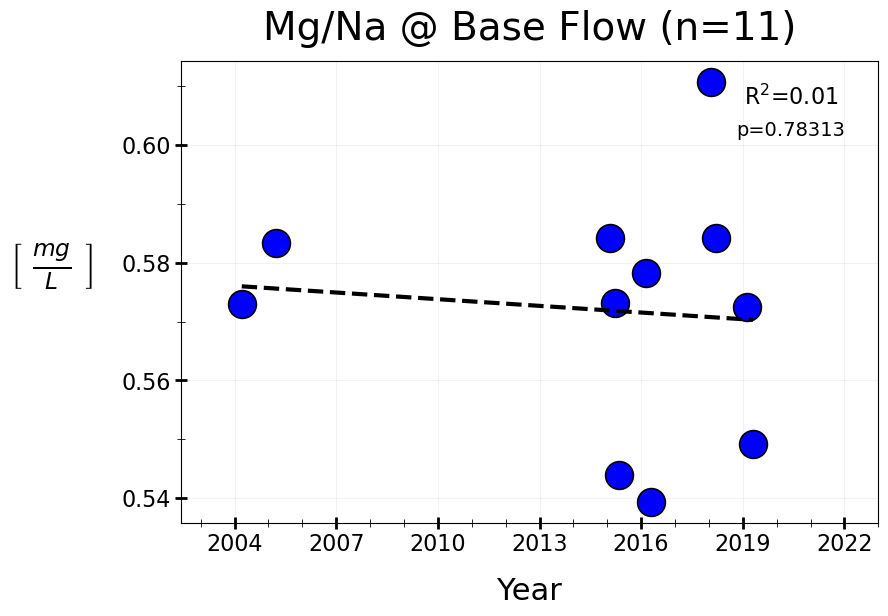

In [57]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="Mg/Na")
#fig.savefig('AGRO_Yenisey_Regression_MgNa_Baseflow.png', dpi=500, bbox_inches='tight')

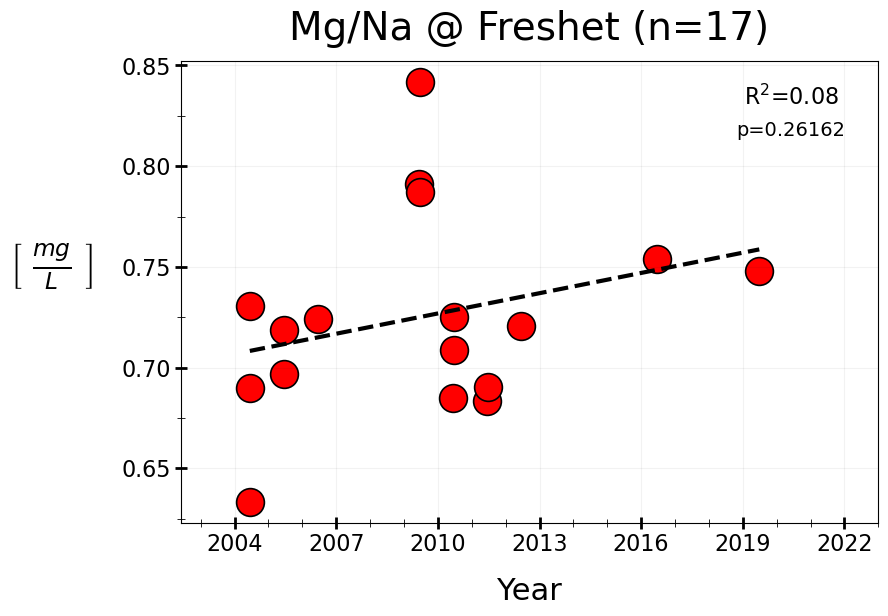

In [58]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="Mg/Na")
#fig.savefig('AGRO_Yenisey_Regression_MgNa_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

### Mg/Ca

<br><br><br>

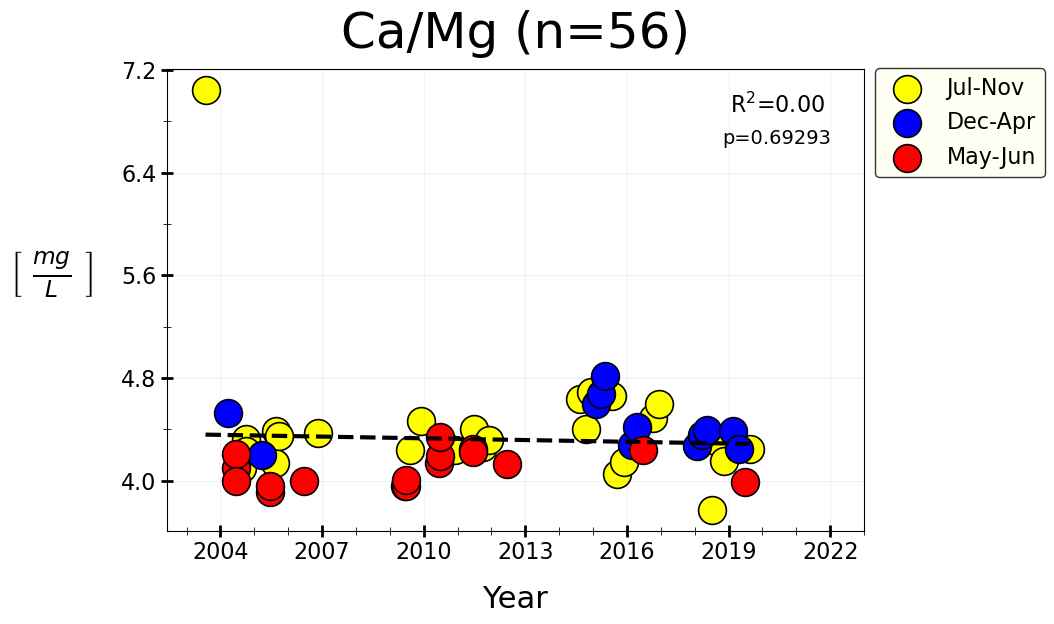

In [59]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="Ca/Mg")
#fig.savefig('AGRO_Yenisey_Regression_CaMg_legend.png', dpi=500, bbox_inches='tight')

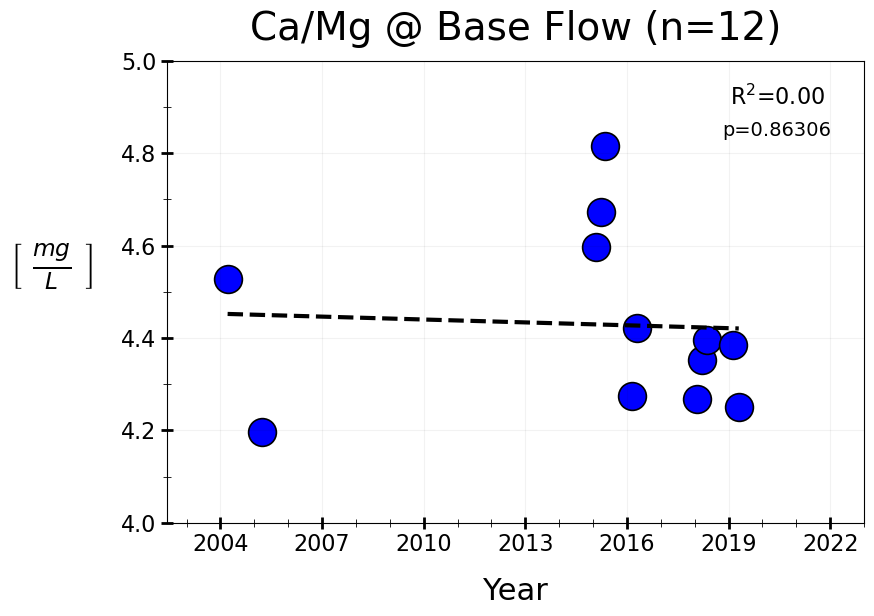

In [60]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="Ca/Mg", y_limits=(4, 5))
#fig.savefig('AGRO_Yenisey_Regression_CaMg_Baseflow.png', dpi=500, bbox_inches='tight')

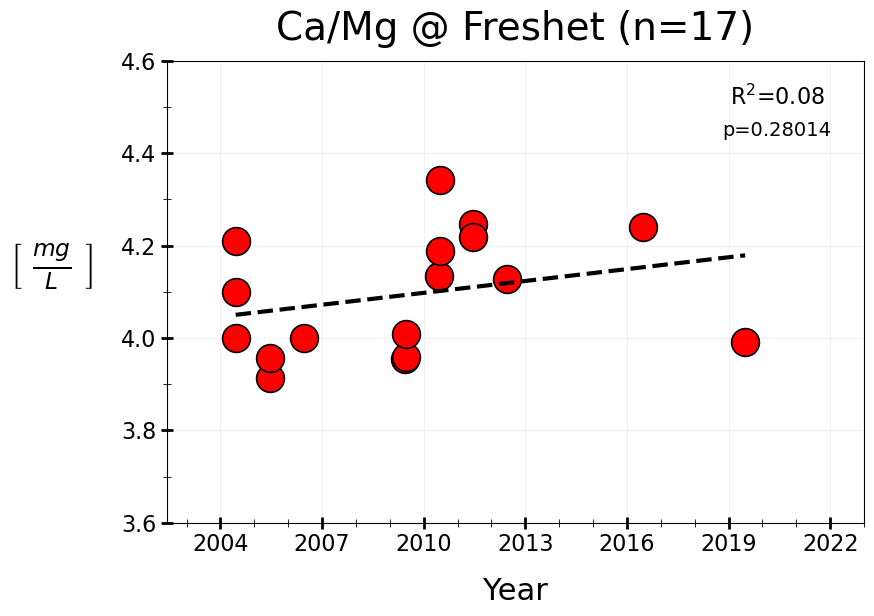

In [61]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="Ca/Mg", y_limits=(3.6, 4.6))
#fig.savefig('AGRO_Yenisey_Regression_CaMg_Freshet.png', dpi=500, bbox_inches='tight')

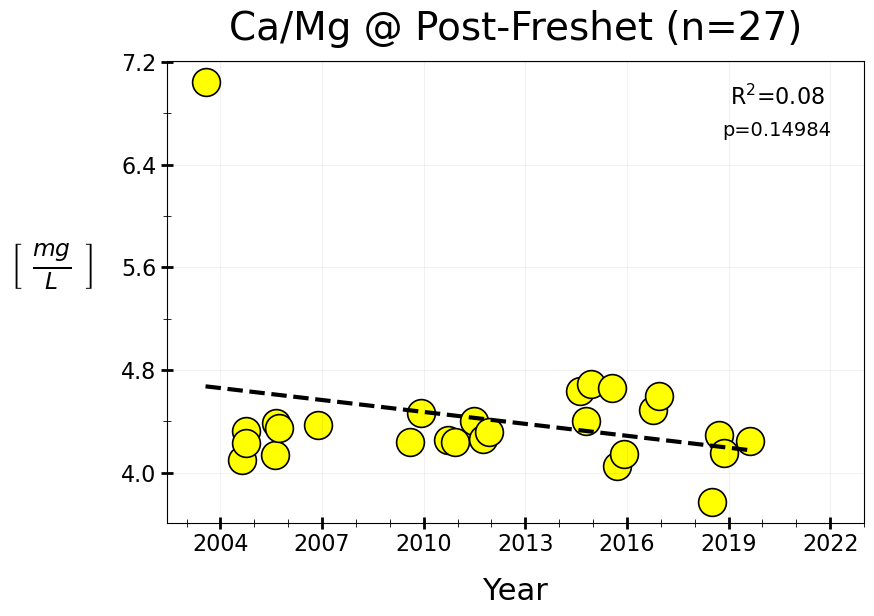

In [62]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df3, column_name="Ca/Mg") # y_limits=(3.6, 4.6)
#fig.savefig('AGRO_Yenisey_Regression_CaMg_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

### Ca/Na and Mg/Na

<br><br><br>

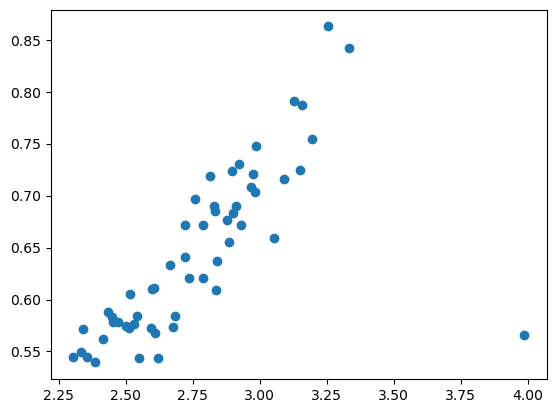

In [63]:
plt.scatter(dfc['Ca/Na'], dfc['Mg/Na'])

In [64]:
# [g/mol] >>> [mg/mol]
CaCO3 = ((40.078) + (12.011) + 3*(15.999))*1000
Ca = (40.078)*1000
Mg = (24.305)*1000
Na = (22.989769)*1000
SO4 = ((32.065) + 4*(15.999))*1000
C = (12.011)*1000

# [mg/L] * [mol/mg] * (10**6) [umol/mol] = [umol/L] 
dfc['Alk_uM'] = dfc['Alk'] * (1/ CaCO3) * (10**6)
dfc['Ca_uM'] = dfc['Ca'] * (1/ Ca) * (10**6)
dfc['Mg_uM'] = dfc['Mg'] * (1/ Mg) * (10**6)
dfc['Na_uM'] = dfc['Na'] * (1/ Na) * (10**6)
dfc['SO4_uM'] = dfc['SO4'] * (1/ SO4) * (10**6)
dfc['DOC_uM'] = dfc['DOC'] * (1/ C) * (10**6)

# [umol/kg]   @    FW_density = 998 [kg/m3]   @   1 [m3] = 1000 [L]
density, L_m3 = 999.82, 999.82
dfc['Alk_uM'] = dfc['Alk_uM'] * (L_m3) * (1/density)
dfc['Ca_uM'] = dfc['Ca_uM'] * (L_m3) * (1/density)
dfc['Mg_uM'] = dfc['Mg_uM'] * (L_m3) * (1/density)
dfc['Na_uM'] = dfc['Na_uM'] * (L_m3) * (1/density)
dfc['SO4_uM'] = dfc['SO4_uM'] * (L_m3) * (1/density)
dfc['DOC_uM'] = dfc['DOC_uM'] * (L_m3) * (1/density)

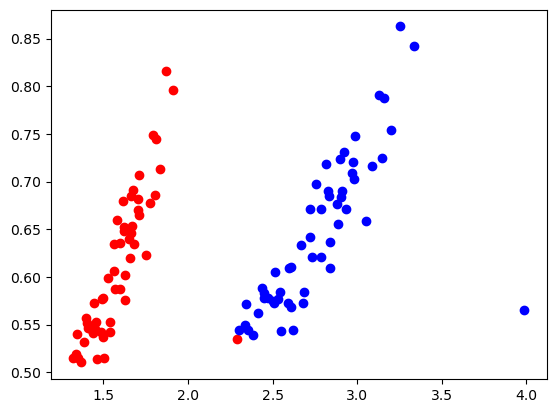

In [65]:
x1 = (dfc['Ca_uM'] / dfc['Na_uM']) 
x2 = (dfc['Mg_uM'] / dfc['Na_uM']) 

plt.scatter(x1,x2, c='red')
plt.scatter(dfc['Ca/Na'], dfc['Mg/Na'], c='blue')

In [66]:
#dfc['Ca/Na'].mean() # 2.7706701773555222
# x1.mean() # 1.5893274951991736

In [67]:
#dfc['Mg/Na'].mean() # 0.6449122267020538
# x2.mean() # 0.6100137057048282

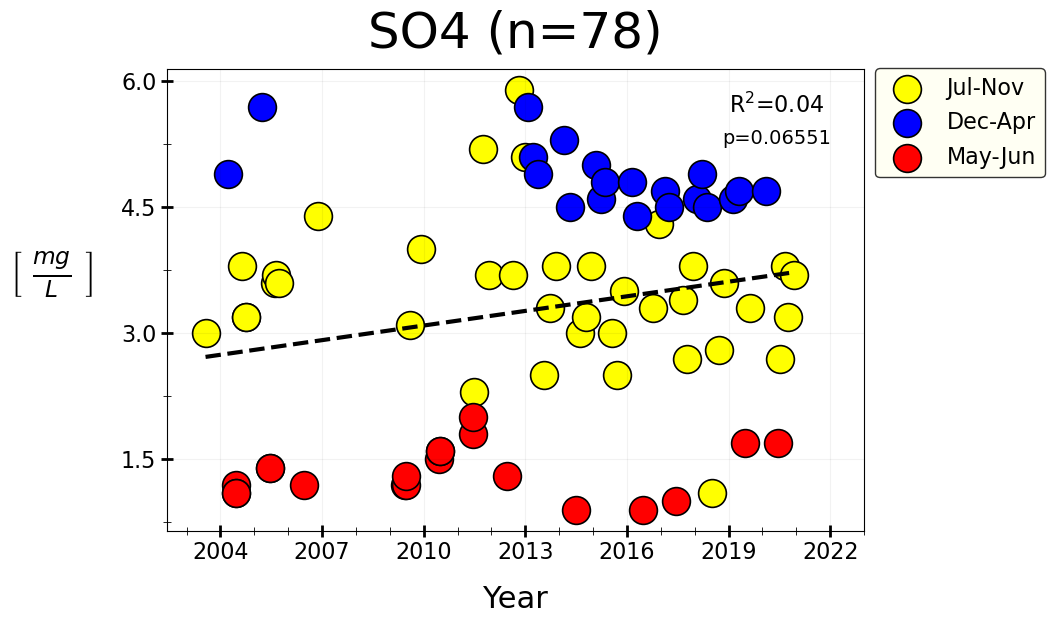

In [69]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="SO4", )

In [68]:
halt

NameError: name 'halt' is not defined

<br><br><br>

### 13C_DOC

<br><br><br>

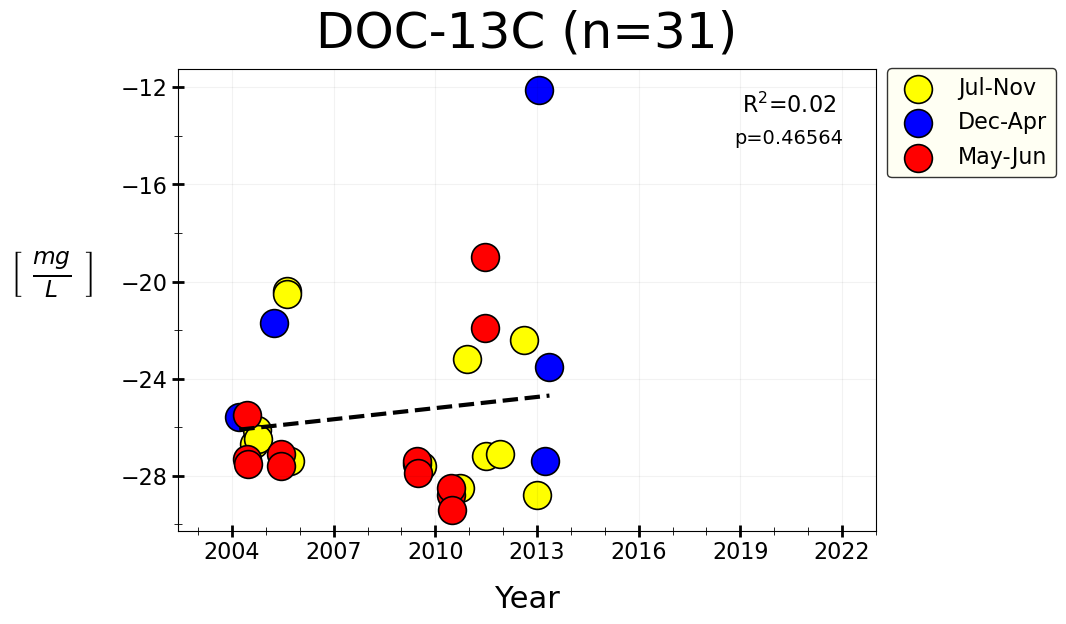

In [70]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="DOC-13C")
#fig.savefig('AGRO_Yenisey_Regression_13C_DOC_legend.png', dpi=500, bbox_inches='tight')

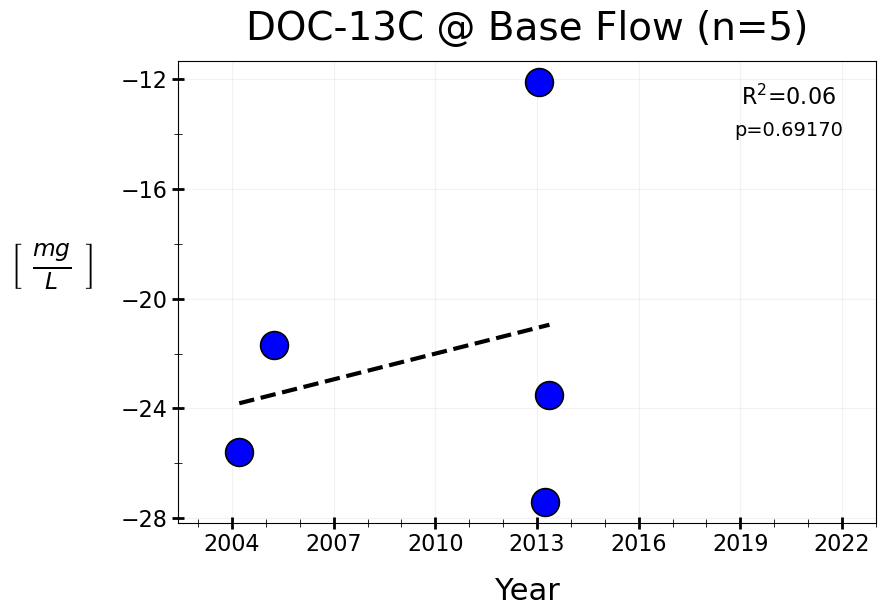

In [71]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="DOC-13C")
#fig.savefig('AGRO_Yenisey_Regression_DOC-13C_Baseflow.png', dpi=500, bbox_inches='tight')

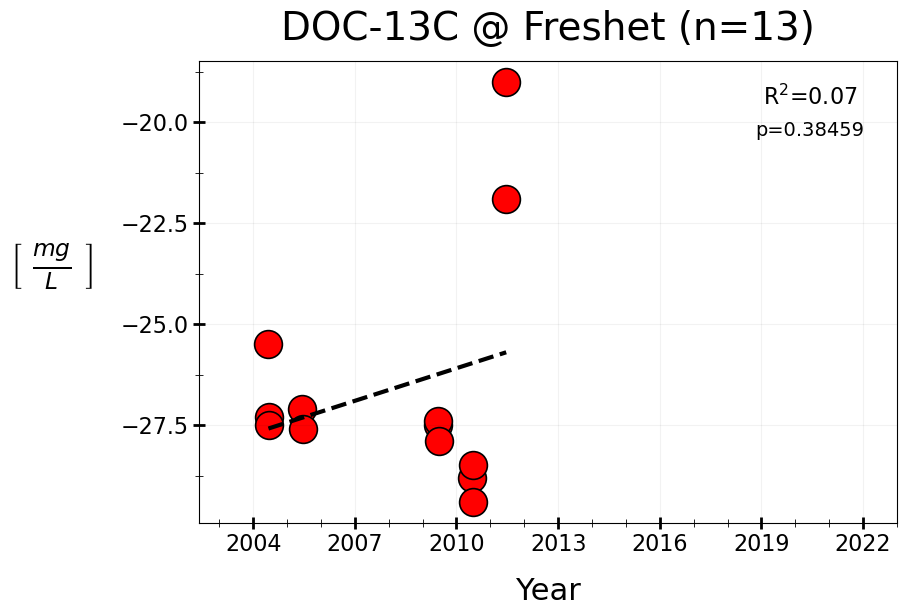

In [72]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="DOC-13C")
#fig.savefig('AGRO_Yenisey_Regression_13C_DOC_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

### 14C_DOC

<br><br><br>

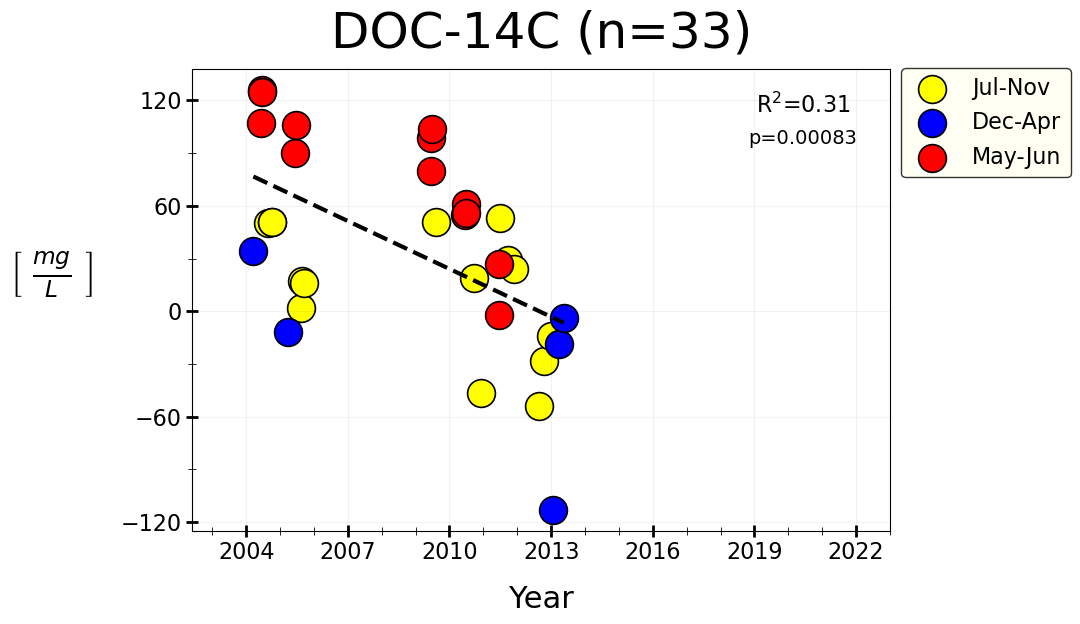

In [73]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="DOC-14C")
fig.savefig('AGRO_Yenisey_Regression_14C_DOC_legend.png', dpi=500, bbox_inches='tight')

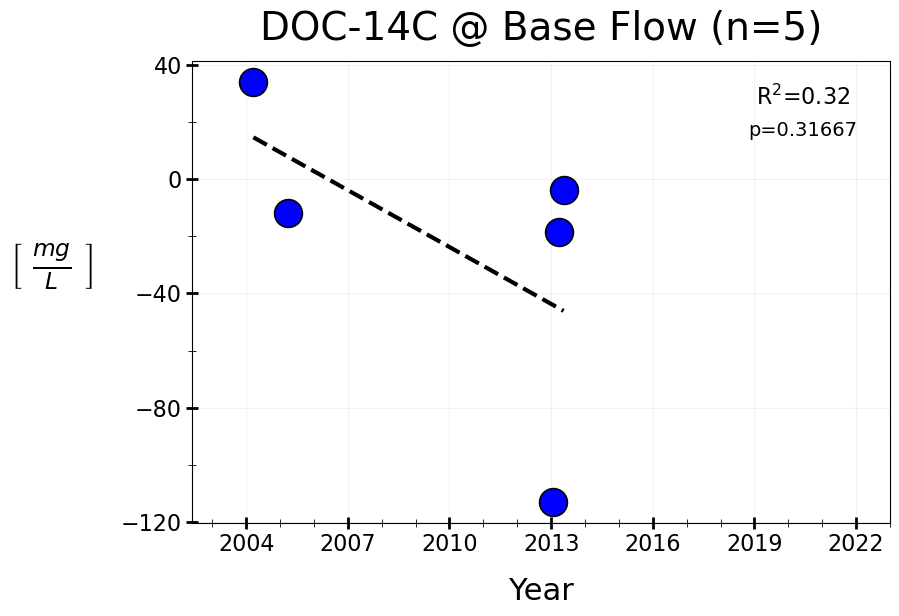

In [74]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="DOC-14C")
fig.savefig('AGRO_Yenisey_Regression_DOC-14C_Baseflow.png', dpi=500, bbox_inches='tight')

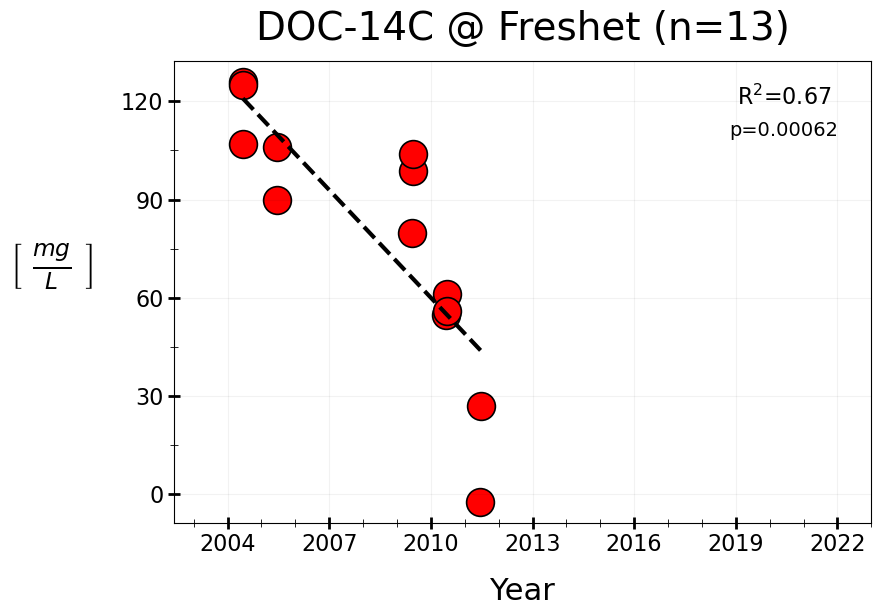

In [75]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="DOC-14C")
fig.savefig('AGRO_Yenisey_Regression_14C_DOC_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

### 13C_POC

<br><br><br>

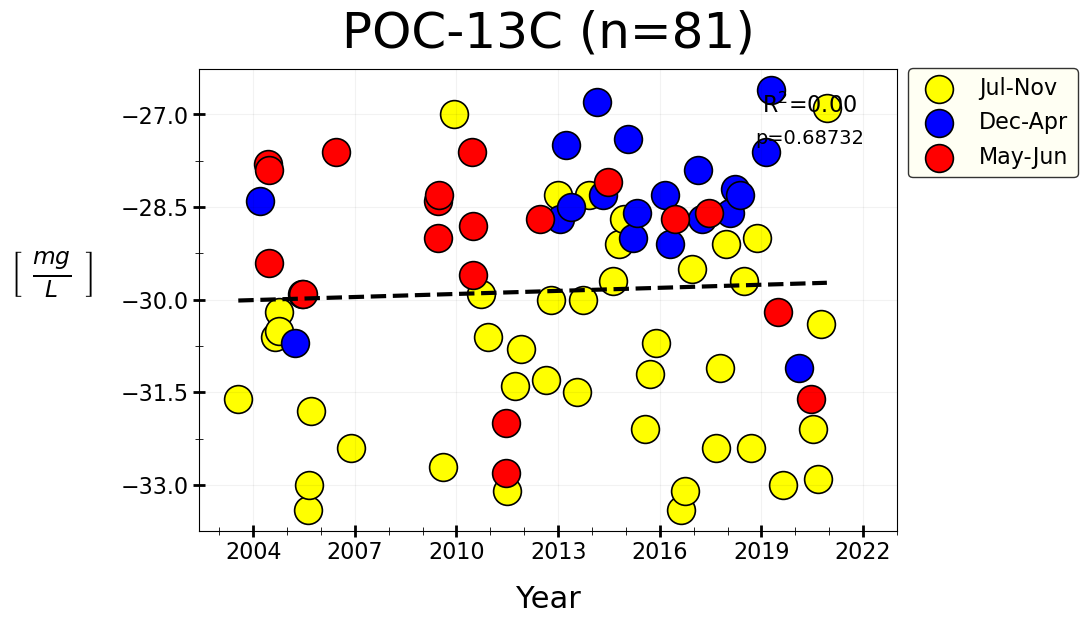

In [76]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="POC-13C")
#fig.savefig('AGRO_Yenisey_Regression_13C_POC_legend.png', dpi=500, bbox_inches='tight')

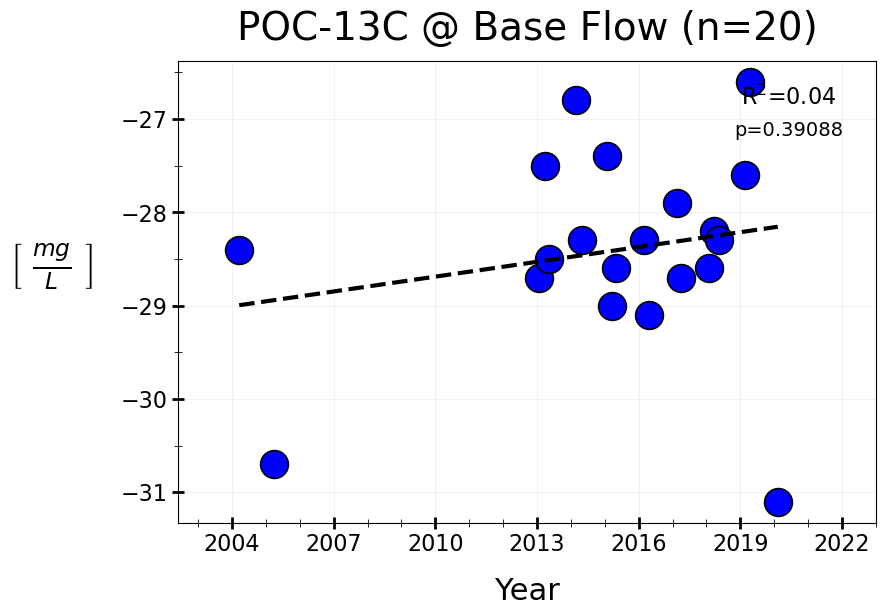

In [77]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="POC-13C")
#fig.savefig('AGRO_Yenisey_Regression_POC-13C_Baseflow.png', dpi=500, bbox_inches='tight')

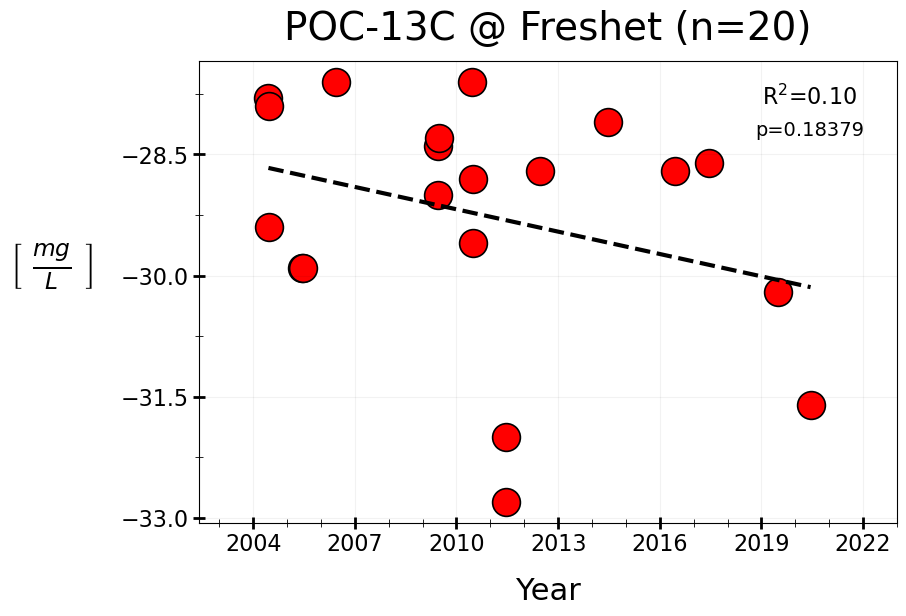

In [78]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="POC-13C")
#fig.savefig('AGRO_Yenisey_Regression_13C_POC_Base.png', dpi=500, bbox_inches='tight')

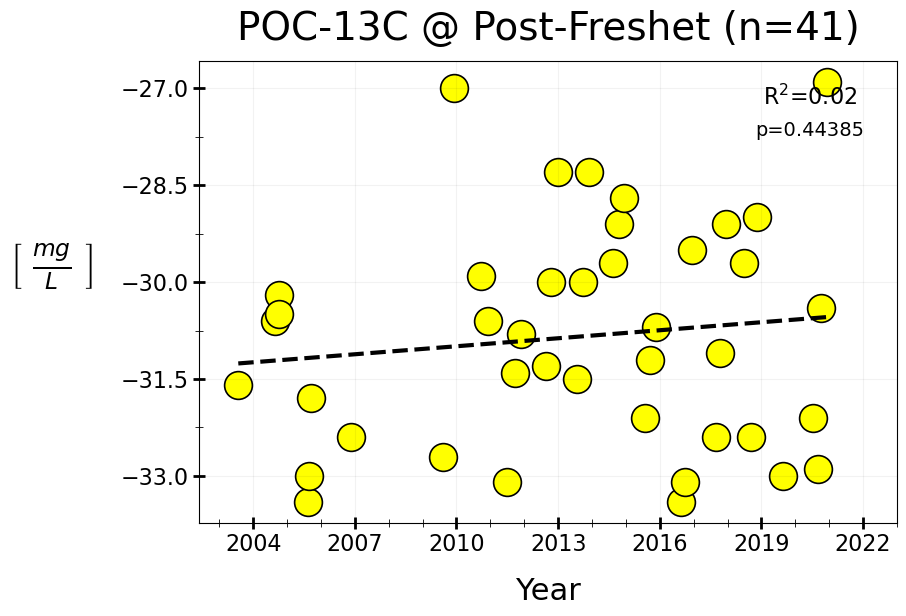

In [79]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df3, column_name="POC-13C")
#fig.savefig('AGRO_Yenisey_Regression_13C_POC_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

### 14C_POC

<br><br><br>

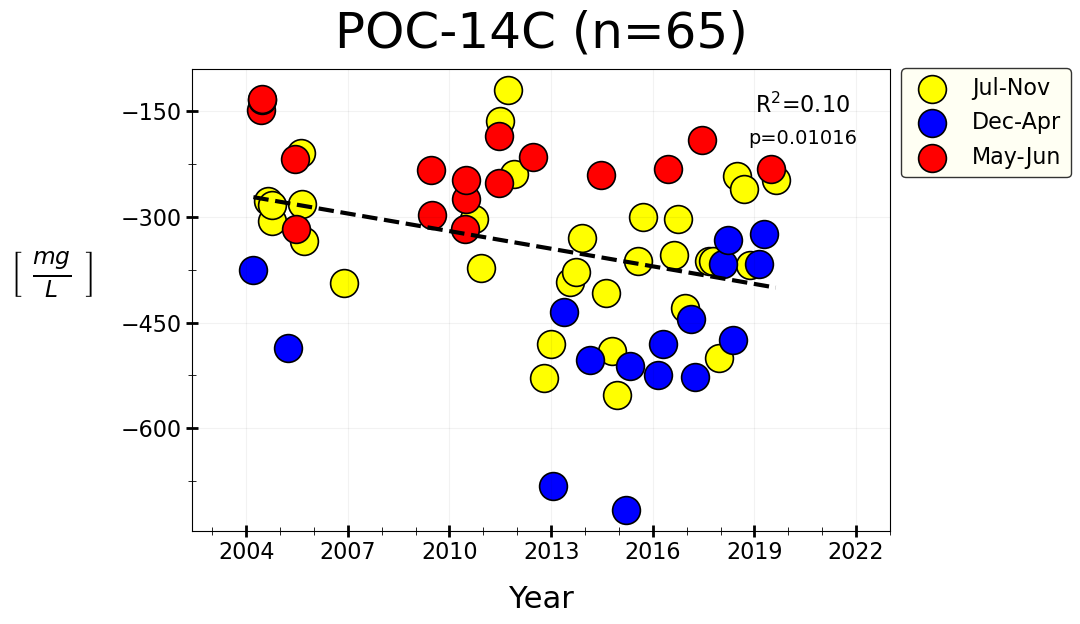

In [80]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="POC-14C")
fig.savefig('AGRO_Yenisey_Regression_14C_POC_legend.png', dpi=500, bbox_inches='tight')

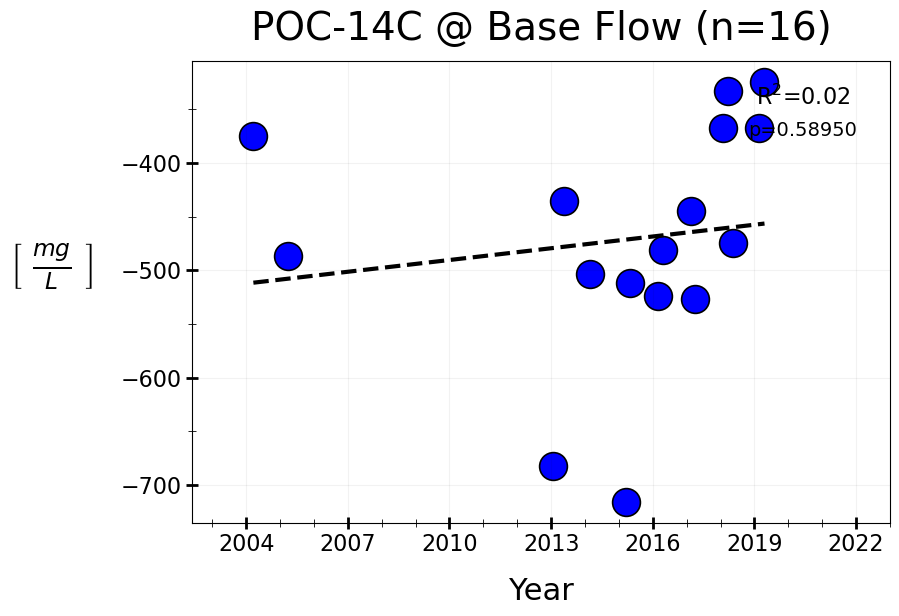

In [81]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="POC-14C")
#fig.savefig('AGRO_Yenisey_Regression_POC-14C_Baseflow.png', dpi=500, bbox_inches='tight')

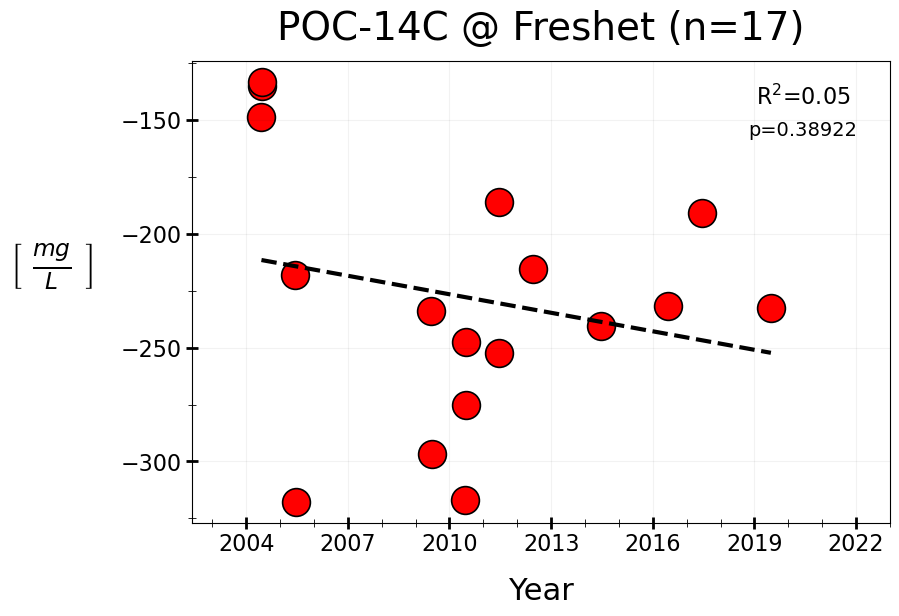

In [82]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="POC-14C")
#fig.savefig('AGRO_Yenisey_Regression_14C_POC_Freshet.png', dpi=500, bbox_inches='tight')

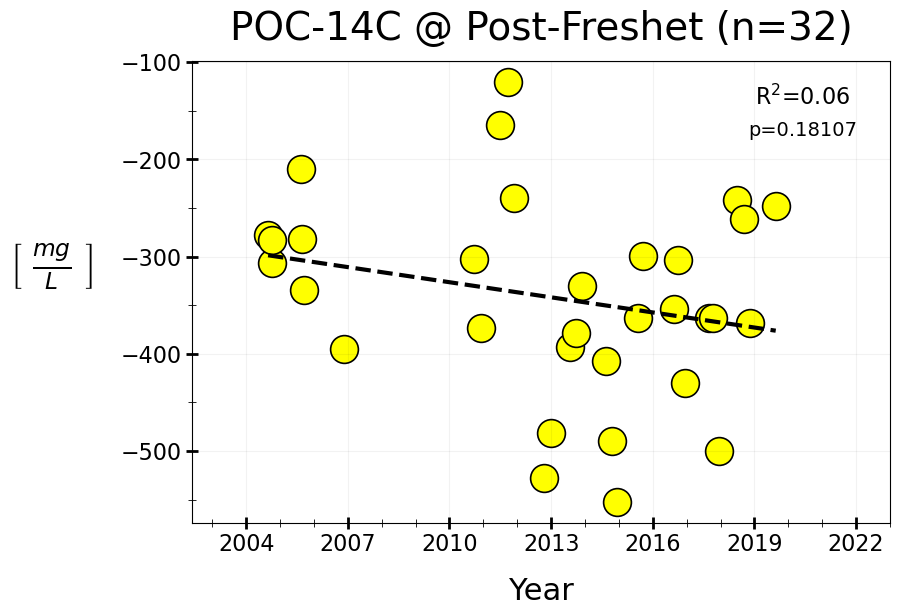

In [83]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df3, column_name="POC-14C")
#fig.savefig('AGRO_Yenisey_Regression_14C_POC_Freshet.png', dpi=500, bbox_inches='tight')

<br><br><br>

### pH

<br><br><br>

In [84]:
def perform_regression_and_plot(dfc, column_name, y_limits=None):
    # Create a new dataframe for analysis
    df = pd.DataFrame()
    df[column_name] = dfc[column_name]
    df['Date'] = dfc['Date']
    df.index = df['Date']
    df['Date_'] = df.index.map(datetime.datetime.toordinal)
    df = df.dropna()

    # Preparing the data for statsmodels
    X = sm.add_constant(df['Date_'])  # adding a constant
    y = df[column_name]

    # Fit the model
    model = sm.OLS(y, X).fit()
    df['model'] = model.predict(X)

    # Extracting coefficients and performance metrics
    a_opt, b_opt = model.params['Date_'], model.params['const']
    R2 = model.rsquared
    p_value = model.pvalues['Date_']

    # Set Plot
    fig, ax = plt.subplots(figsize=(9,6))

    # Define colors and labels
    colors = {0: 'blue', 1: 'red', 2: 'yellow'}
    labels = ['Dec-Apr', 'May-Jun', 'Jul-Nov']

    # Plot Observed Data with Color
    for season in dfc['season'].unique():
        ax.scatter(dfc.loc[dfc['season'] == season, 'Date'], dfc.loc[dfc['season'] == season, column_name],
                   c=colors[season], edgecolor='black', lw=1.2, s=400, zorder=1, label=labels[season])

    # Plot Modeled Data
    ax.plot(df['Date'], df['model'], c='black', lw=3, ls='--', zorder=3)

    # Labels and Axes
    ax.set_title(f'{column_name} (n={df.shape[0]})', fontsize=36, c='black', pad=15)
    #ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)
    ax.set_xlabel('Year', fontsize=22, c='black', labelpad=15)

    ax.set_xlim(pd.Timestamp('2002-06-01'), pd.Timestamp('2023-01-01'))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))  
    ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

    if y_limits:
        ax.set_ylim(*y_limits)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

    ax.text(0.875, 0.92, rf"R$^2$={R2:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.875, 0.85, f"p={p_value:.5f}", fontsize=14, color='black', 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(color='black', alpha=0.05)
    ax.legend(loc=1, bbox_to_anchor=(1.275, 1.025), facecolor='ivory', edgecolor='black', fontsize=16)

    plt.show()

    return fig, ax

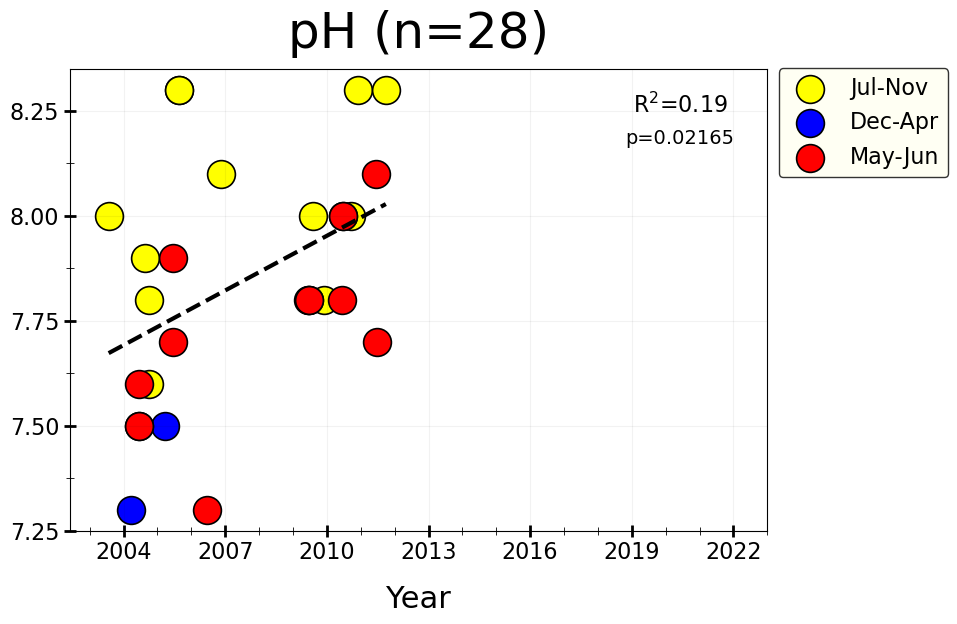

In [85]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="pH")
fig.savefig('AGRO_Yenisey_Regression_pH_legend.png', dpi=500, bbox_inches='tight')

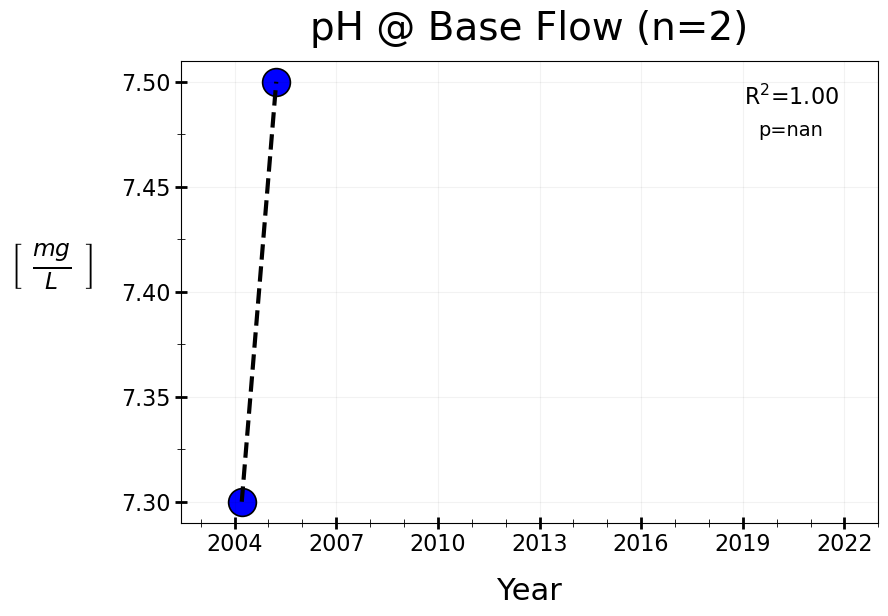

In [86]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="pH")
#fig.savefig('AGRO_Yenisey_Regression_pH_Baseflow.png', dpi=500, bbox_inches='tight')

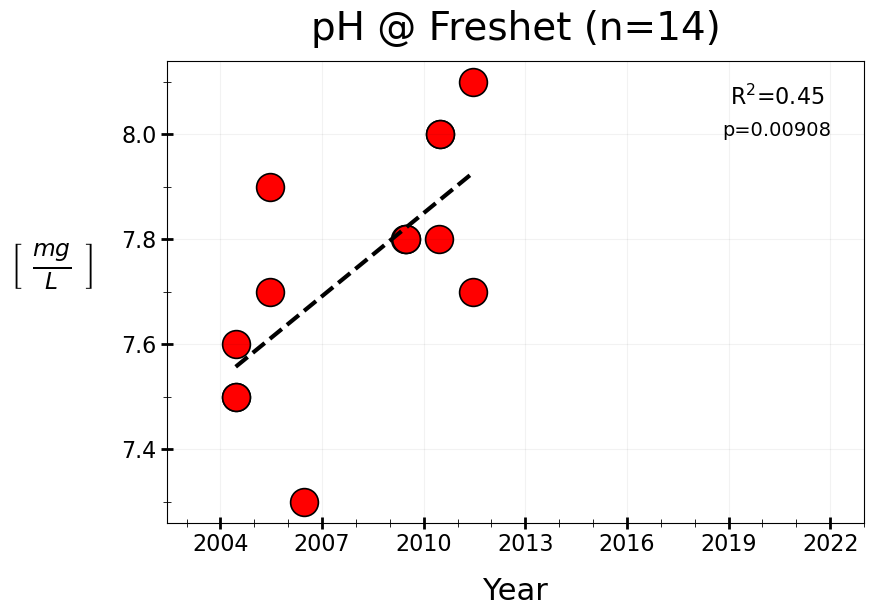

In [87]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df2, column_name="pH")
#fig.savefig('AGRO_Yenisey_Regression_pH_Freshet.png', dpi=500, bbox_inches='tight')

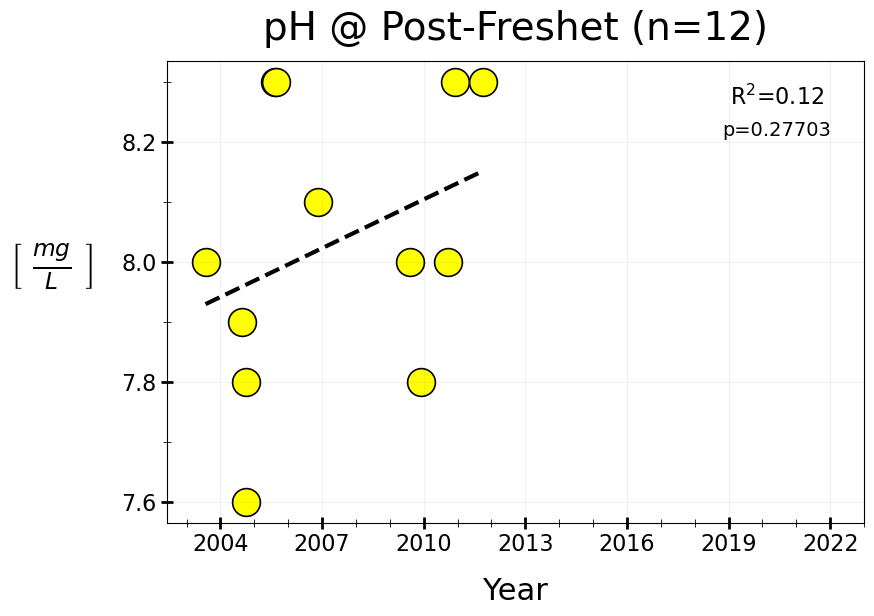

In [88]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df3, column_name="pH")
#fig.savefig('AGRO_Yenisey_Regression_pH_Post_Freshet.png', dpi=500, bbox_inches='tight')

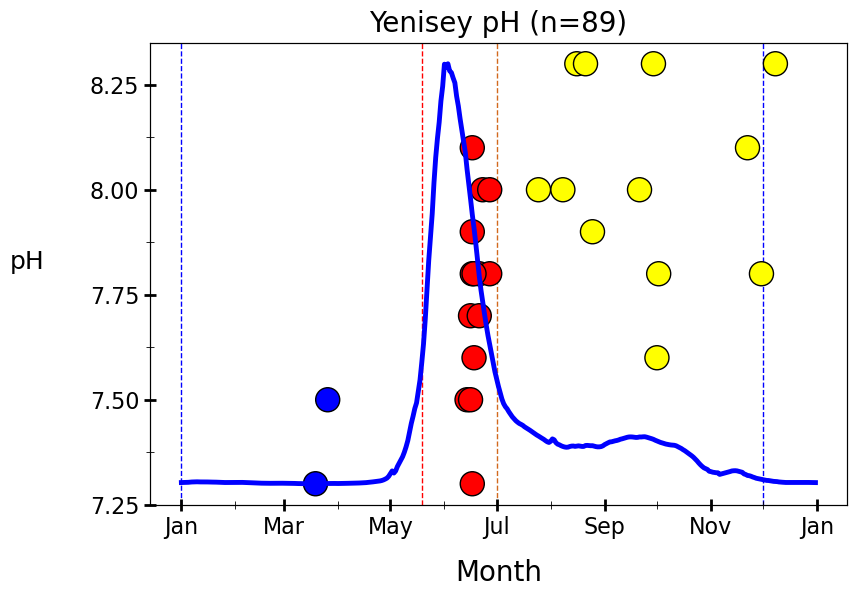

In [89]:
# Plot
fig, ax = plt.subplots(figsize=(9,6))

# Titles
ax.set_title(f'Yenisey pH (n={dfc.shape[0]})', fontsize=20, c='black', pad=8)

# Data Points
ax.scatter(dfc['month_day'], dfc['pH'], c=dfc['season'].map(colors), edgecolor='black', s=300, lw=1.0, ls='-', zorder=2)

# Labels (x)
ax.set_xlabel('Month', fontsize=20, c='black', labelpad=15)

# Labels (y)
ax.set_ylabel('pH', fontsize=18, c='black', labelpad=45, rotation=0)

# Second Axis: Discharge
ax1 = ax.twinx()

# Second Axis: Ticks
ax1.yaxis.set_ticks([])

# Second Axis: Plot
ax1.plot(dfq_daily.index, dfq_daily['q_m3/s'], c='blue', lw=3.5, ls='-', zorder=1)
#ax1.fill_between(dfq_daily.index, dfq_daily['lower_y'], dfq_daily['upper_y'], label="95% CI", color="deepskyblue", edgecolor="black", lw=1, alpha=1, ls='-', zorder=2)

ax.xaxis.set_major_formatter(month_name)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.xaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax.yaxis.set_tick_params(which='major', direction='inout',length=8,labelsize=16, width=2)
ax.yaxis.set_tick_params(which='minor', direction='inout',length=6, labelsize=16)
#ax.axvline(pd.Timestamp('1900-03-21'), color='green', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-06-21'), color='red', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-09-21'), color='chocolate', lw=1, ls='--', zorder=0)
#ax.axvline(pd.Timestamp('1900-12-21'), color='blue', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-01-01'), color='blue', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-05-19'), color='red', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-07-01'), color='chocolate', lw=1, ls='--', zorder=0)
ax.axvline(pd.Timestamp('1900-12-01'), color='blue', lw=1, ls='--', zorder=0)

#fig.suptitle('Siberian Rivers (2003-2021)', fontsize=32, x=0.58, y=1.005)

#fig.savefig('AGRO_Daily_T_Month_Day.png', dpi = 500, bbox_inches='tight')

In [90]:
def perform_regression_and_plot(dfc, column_name, y_limits=None):
    # Create a new dataframe for analysis
    df = pd.DataFrame()
    df[column_name] = dfc[column_name]
    df['Date'] = dfc['Date']
    df.index = df['Date']
    df['Date_'] = df.index.map(datetime.datetime.toordinal)
    df = df.dropna()

    # Preparing the data for statsmodels
    X = sm.add_constant(df['Date_'])  # adding a constant
    y = df[column_name]

    # Fit the model
    model = sm.OLS(y, X).fit()
    df['model'] = model.predict(X)

    # Extracting coefficients and performance metrics
    a_opt, b_opt = model.params['Date_'], model.params['const']
    R2 = model.rsquared
    p_value = model.pvalues['Date_']

    # Set Plot
    fig, ax = plt.subplots(figsize=(9,6))

    # Define colors and labels
    colors = {0: 'blue', 1: 'red', 2: 'yellow'}
    labels = ['Dec-Apr', 'May-Jun', 'Jul-Nov']

    # Plot Observed Data with Color
    for season in dfc['season'].unique():
        ax.scatter(dfc.loc[dfc['season'] == season, 'Date'], dfc.loc[dfc['season'] == season, column_name],
                   c=colors[season], edgecolor='black', lw=1.2, s=400, zorder=1, label=labels[season])

    # Plot Modeled Data
    ax.plot(df['Date'], df['model'], c='black', lw=3, ls='--', zorder=3)

    # Labels and Axes
    ax.set_title(f'{column_name} (n={df.shape[0]})', fontsize=36, c='black', pad=15)
    ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)
    ax.set_xlabel('Year', fontsize=22, c='black', labelpad=15)

    ax.set_xlim(pd.Timestamp('2002-06-01'), pd.Timestamp('2023-01-01'))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))  
    ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

    if y_limits:
        ax.set_ylim(*y_limits)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

    ax.text(0.875, 0.92, rf"R$^2$={R2:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.875, 0.85, f"p={p_value:.5f}", fontsize=14, color='black', 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(color='black', alpha=0.05)
    ax.legend(loc=1, bbox_to_anchor=(1.275, 1.025), facecolor='ivory', edgecolor='black', fontsize=16)

    plt.show()

    return fig, ax

In [91]:
def perform_regression_and_plot_seasonal(dfc, column_name, y_limits=None):
        global df1, df2, df3
        # Determine the title based on the DataFrame
        if dfc.equals(df1):
            title = 'Base Flow'
        elif dfc.equals(df2):
            title = 'Freshet'
        elif dfc.equals(df3):
            title = 'Post-Freshet'
        else:
            title = 'Unknown'  # Default title
            
        # Create a new dataframe for analysis
        df = pd.DataFrame()
        df[column_name] = dfc[column_name]
        df['Date'] = dfc['Date']
        df.index = df['Date']
        df['Date_'] = df.index.map(datetime.datetime.toordinal)
        df = df.dropna()

        # Preparing the data for statsmodels
        X = sm.add_constant(df['Date_'])  # adding a constant
        y = df[column_name]

        # Fit the model
        model = sm.OLS(y, X).fit()
        df['model'] = model.predict(X)

        # Extracting coefficients and performance metrics
        a_opt, b_opt = model.params['Date_'], model.params['const']
        R2 = model.rsquared
        p_value = model.pvalues['Date_']
        
        # Set Plot
        fig, ax = plt.subplots(figsize=(9,6))

        # Define colors and labels
        colors = {0: 'blue', 1: 'red', 2: 'yellow'}
        labels = ['Dec-Apr', 'May-Jun', 'Jul-Nov']
    
        # Plot Observed Data with Color
        for season in dfc['season'].unique():
            ax.scatter(dfc.loc[dfc['season'] == season, 'Date'], dfc.loc[dfc['season'] == season, column_name],
                       c=colors[season], edgecolor='black', lw=1.2, s=400, zorder=1, label=labels[season])

        # Plot Modeled Data
        ax.plot(df['Date'], df['model'], c='black', lw=3, ls='--', zorder=3)

        # Labels and Axes
        ax.set_title(f'{column_name} @ {title} (n={df.shape[0]})', fontsize=28, c='black', pad=15)
        ax.set_ylabel(r'$^o$C', fontsize=24, color='black', labelpad=50, rotation=0)
        ax.set_xlabel('Year', fontsize=22, c='black', labelpad=15)

        ax.set_xlim(pd.Timestamp('2002-06-01'), pd.Timestamp('2023-01-01'))
        ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))
        ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))  
        ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
        ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)
    
        if y_limits:
            ax.set_ylim(*y_limits)
        ax.yaxis.set_major_locator(MaxNLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
        ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

        ax.text(0.15, 0.92, rf"R$^2$={R2:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.15, 0.85, f"p={p_value:.5f}", fontsize=14, color='black', 
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.grid(color='black', alpha=0.05)
        #ax.legend(loc=1, bbox_to_anchor=(1.275, 1.025), facecolor='ivory', edgecolor='black', fontsize=16)

        plt.show()

        return fig, ax

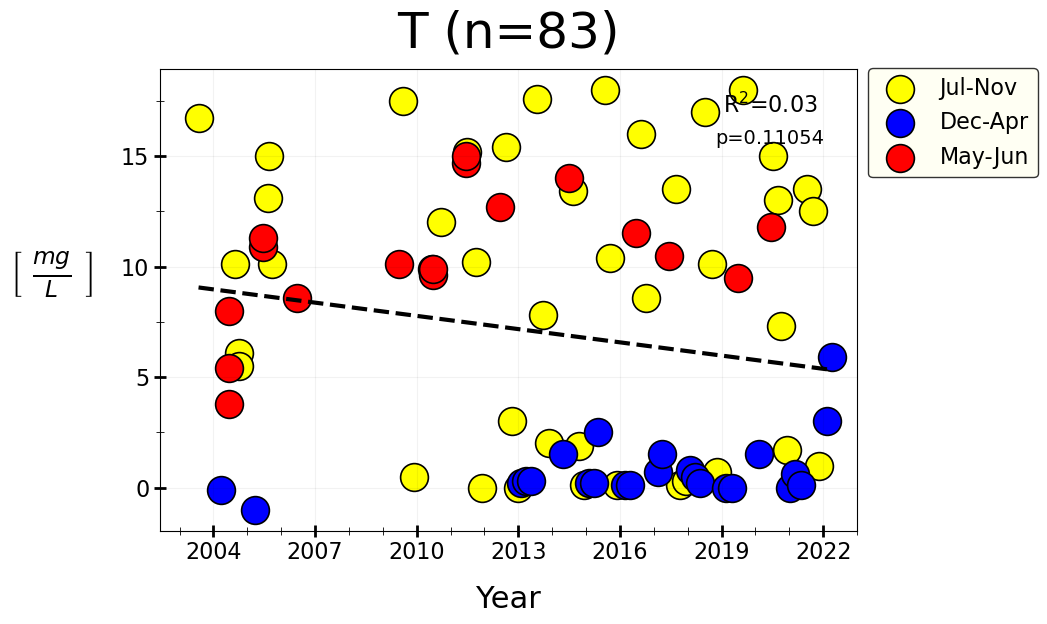

In [92]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="T")
#fig.savefig('AGRO_Yenisey_Regression_T_base.png', dpi=500, bbox_inches='tight')

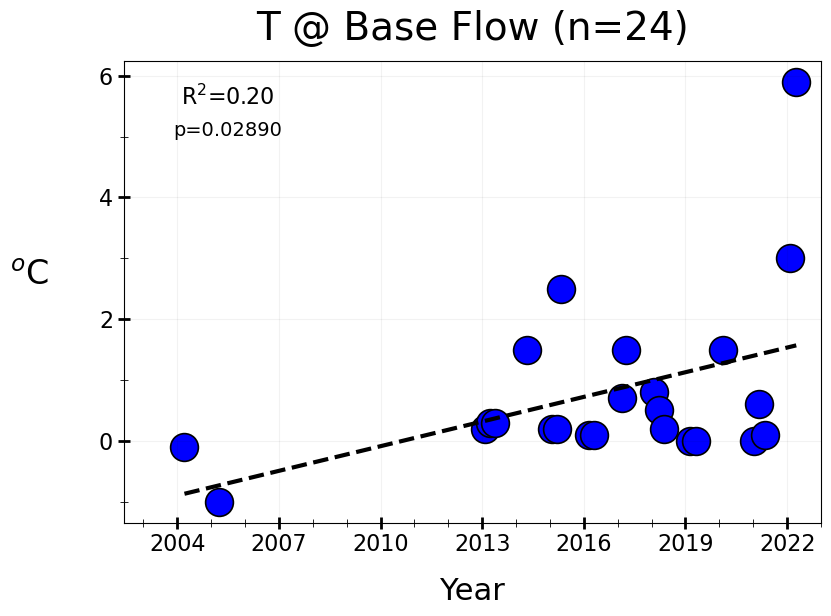

In [93]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, column_name="T")
fig.savefig('AGRO_Yenisey_Regression_T_base.png', dpi=500, bbox_inches='tight')

In [ ]:
os.getcwd()

In [ ]:
haly

In [ ]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="Sr")
#fig.savefig('AGRO_Yenisey_Regression_Sr_legend.png', dpi=500, bbox_inches='tight')

In [ ]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="SO4")
#fig.savefig('AGRO_Yenisey_Regression_SO4_legend.png', dpi=500, bbox_inches='tight')

In [ ]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="NO3")
#fig.savefig('AGRO_Yenisey_Regression_NO3_legend.png', dpi=500, bbox_inches='tight')

In [ ]:
fig, ax = perform_regression_and_plot(dfc=dfc, column_name="Ba")
#fig.savefig('AGRO_Yenisey_Regression_Ba_legend.png', dpi=500, bbox_inches='tight')

In [ ]:
halt
# Old Seasonal

In [ ]:
def perform_regression_and_plot_seasonal(dfc, title, column_name, y_limits=None):
    # Create a new dataframe for analysis
    df = pd.DataFrame()
    df[column_name] = dfc[column_name]
    df['Date'] = dfc['Date']
    df.index = df['Date']
    df['Date_'] = df.index.map(datetime.datetime.toordinal)
    df = df.dropna()

    # Preparing the data for statsmodels
    X = sm.add_constant(df['Date_'])  # adding a constant
    y = df[column_name]

    # Fit the model
    model = sm.OLS(y, X).fit()
    df['model'] = model.predict(X)

    # Extracting coefficients and performance metrics
    a_opt, b_opt = model.params['Date_'], model.params['const']
    R2 = model.rsquared

    # Set Plot
    fig, ax = plt.subplots(figsize=(9,6))

    # Define colors and labels
    colors = {0: 'blue', 1: 'red', 2: 'yellow'}
    labels = ['Dec-Apr', 'May-Jun', 'Jul-Nov']

    # Plot Observed Data with Color
    for season in dfc['season'].unique():
        ax.scatter(dfc.loc[dfc['season'] == season, 'Date'], dfc.loc[dfc['season'] == season, column_name],
                   c=colors[season], edgecolor='black', lw=1.2, s=400, zorder=1, label=labels[season])

    # Plot Modeled Data
    ax.plot(df['Date'], df['model'], c='black', lw=3, ls='--', zorder=3)

    # Labels and Axes
    ax.set_title(f'{column_name} @ {title} (n={df.shape[0]})', fontsize=28, c='black', pad=15)
    ax.set_ylabel(r'$\left[\ \frac{mg}{L}\ \right]$', fontsize=24, color='black', labelpad=50, rotation=0)
    ax.set_xlabel('Year', fontsize=22, c='black', labelpad=15)

    ax.set_xlim(pd.Timestamp('2002-06-01'), pd.Timestamp('2023-01-01'))
    ax.xaxis.set_major_locator(mdates.YearLocator(base=3))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(base=1))  
    ax.xaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.xaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

    if y_limits:
        ax.set_ylim(*y_limits)
    ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_tick_params(which='major', direction='inout', length=8, labelsize=16, width=2)
    ax.yaxis.set_tick_params(which='minor', direction='inout', length=6, labelsize=16)

    ax.text(0.875, 0.92, rf"R$^2$={R2:.2f}", fontsize=16, color='black', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.grid(color='black', alpha=0.05)
    #ax.legend(loc=1, bbox_to_anchor=(1.275, 1.025), facecolor='ivory', edgecolor='black', fontsize=16)

    plt.show()

    return fig, ax

In [ ]:
fig, ax = perform_regression_and_plot_seasonal(dfc=df1, title='Base Flow', column_name="POC", y_limits=(0, 1))
#fig.savefig('AGRO_Yenisey_Regression_POC_legend.png', dpi=500, bbox_inches='tight')

fig, ax = perform_regression_and_plot_seasonal(dfc=df2, title='Freshet', column_name="POC", y_limits=(0, 1))
#fig.savefig('AGRO_Yenisey_Regression_POC_legend.png', dpi=500, bbox_inches='tight')

fig, ax = perform_regression_and_plot_seasonal(dfc=df3, title='Post-Freshet', column_name="POC", y_limits=(0, 1))
#fig.savefig('AGRO_Yenisey_Regression_POC_legend.png', dpi=500, bbox_inches='tight')